# Productive runs with high lift short domain

# 1. Create cases


In [1]:
# this cell ensures that python modules are reloaded at runtime

# reload modules
%reload_ext autoreload
%autoreload 2

In [1]:
import pandas

### Set mesh and domain parameters

In [1]:


# create refined mesh

# inilitialize dictionaries
mesh   = {}

# case name and profile coordinates
casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesclean'

# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\NoTurbZero'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\NoTurbNeg'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\NoTurbPos'

# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\HighTurbZero'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\HighTurbNeg'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\HighTurbPos'


mesh['case'] = casename
mesh['profile'] = 'geom/LS_SPLEEN_PROFILE_10k.txt'

# initial mesh inputs
mesh['npp'] = 2*[None]
mesh['ywall'] = 2*[None]
mesh['msmooths'] = 2*[None]

# Domain inputs
# mesh['Lup'] = 1.5 # length of upstream domain in axial chords - long domain
# mesh['Ldn'] = 1.0 # length of downstream domain in axial chords - long domain
mesh['Lup'] = 0.8 # length of upstream domain in axial chords - short domain
mesh['Ldn'] = 0.8 # length of downstream domain in axial chords - short domain
mesh['Lo'] = 0.1 # dist. from blade surface to bounding box (see paper diagram)
mesh['cor_fac'] = 0.75 # factor shrinking multi-block corner cells - lower values give more shrinkage.

# coarse mesh inputs
mesh['npp'][0] = 8 # number of points per patch 
mesh['ywall'][0] = 0.01 # wall normal spacing
mesh['msmooths'][0] = 1000 # Smoothing iterations?


# final mesh inputs - used to set the final mesh points
mesh['npp'][1] = 24 # points per patch
mesh['msmooths'][1] = 1000 # smoothing iterations?


mesh['ywall'][1] =  0.001/50 # wall normal spacing 5e-5, yplusavg=0.8, yplusmax=1.5 Task4 150M med mesh

mesh['refine_fac'] = 18 # Refinement in ij directions, short productive


# scale factor if used (set to 1.0 if not)
mesh['scale_factor'] = 1.0

# flip y coordinates if -1 (1 for no flip)
mesh['flip'] = 1



### Mesh

In [2]:
from meshing.blade_mesher import *
import timeit

start = timeit.default_timer()

# create mesh 
case = blade_mesher(mesh)

stop = timeit.default_timer()

print('Time: ', round((stop - start)/60,2), 'mins')  

N  10001
Pitch  0.06125
iLE, iTE 71 4967
xLE, yLE -0.000475105 0.001211256
xTE, yTE 0.062535685 -0.033463411
Cax  0.06301079
Stag  28.823869631022923
Time:  11.95 mins


### View mesh

In [3]:
import matplotlib.pyplot as plt

# pop-out figures
%matplotlib qt
#%matplotlib inline

# unpack case for plotting
blk = case['blk']
# plot profile, topology and mesh
plt.figure(1)
plt.axis('equal')
for ib in range(len(blk)):
    xnew=blk[ib]['x']
    ynew=blk[ib]['y']
    plt.plot(xnew,ynew,'k')
    plt.plot(np.transpose(xnew),np.transpose(ynew),'k')

plt.show()

### Interpolate solution and set BCs

In [4]:
from postpro.interp_flo import *
from meshing.read_case import *
from meshing.write_flo import *
from meshing.write_case import *


# interpolate old flow files onto new grid
# casename_old = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main\task4'
# casename_new = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivity\finemesh'

# casename_old = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main\task3noturb'
# casename_new = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\NoTurbZero'

casename_old = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug16'
casename_new = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesclean'

# read casefiles from old directory
case_old = read_case(casename_old)

# pack-up new case
case['casename'] = casename_new
case['bcs'] = case_old['bcs']
case['gas'] = case_old['gas']
case['solver'] = case_old['solver']


# set number of spanwise points
case['solver']['nk'] = 51 # spanwise points for 3D calculation - gives z+<10 avg
# case['solver']['nk'] = 21 # spanwise points for 3D calculation - for debug

# adjust number of iterations
# case['solver']['niter'] = 50000
case['solver']['niter'] = 140000

# adjust filter coefficient
case['solver']['sigma'] = 0.01 # set filter coefficient (finer meshes permit lower values)

# case['solver']['istats'] = 2 # switch-on time-averaging (istats=2 does a spanwise average as well for 2D stats)
case['solver']['istats'] = 0 # switch-on time-averaging (istats=2 does a spanwise average as well for 2D stats)

# Tuned using coarser mesh to get proper BCs for higher turb
# case['bcs']['vin'] = 10.3
# case['bcs']['alpha'] = 42
case['bcs']['vin'] = 11.3
case['bcs']['alpha'] = 36

case['bcs']['aturb'] = 0 # amplification factor for turbulence - 0
case['bcs']['ilength'] = 0 # inlet turbulence generation frequency (no. steps) - 0
# case['bcs']['aturb'] = 17 # amplification factor for turbulence - low
# case['bcs']['ilength'] = 500 # inlet turbulence generation frequency (no. steps) - low
# case['bcs']['aturb'] = 75 # amplification factor for turbulence - high
# case['bcs']['ilength'] = 1000 # inlet turbulence generation frequency (no. steps) - high

start = timeit.default_timer()

# write new casefiles
write_case(case)

# interpolate onto new mesh
prop = interp_flo(casename_old,casename_new)

# write the new flo files
write_flo(prop,casename_new)

stop = timeit.default_timer()
print('Time: ', round((stop - start)/60,2), 'mins')  


Writing inputs for 3dns_gpu
Total ij points
1119744
Total GPUs
4
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Not interpolating mut_model
Not interpolating area
Time:  6.26 mins


### Visualise mesh and export images

(-0.9, 1.9, -1.4, 0.4)

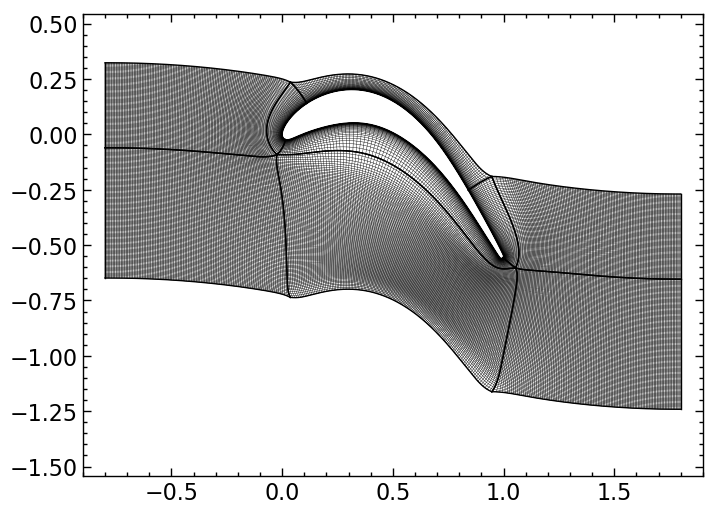

In [60]:
from postpro.read_case import *
import scienceplots

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesturb'

every_nth = 4 # Show every nth grid line

# %matplotlib qt
%matplotlib inline

case = read_case(casename)
blk = case['blk']

with plt.style.context(['science', 'notebook']):
    plt.figure(1)
    plt.axis('equal')
    for ib in range(len(blk)):
        x=blk[ib]['x']
        y=blk[ib]['y']
        plt.plot(x[0,:],y[0,:],'k', linewidth=1)
        plt.plot(x[-1,:],y[-1,:],'k', linewidth=1)
        plt.plot(x[:,0],y[:,0],'k', linewidth=1)
        plt.plot(x[:,-1],y[:,-1],'k', linewidth=1)
        # Plot every nth line in i-direction (rows)
        for i in range(0, x.shape[0], every_nth):
            plt.plot(x[i,:], y[i,:], 'k', linewidth=0.3)
        # Plot every nth line in j-direction (cols)
        for j in range(0, x.shape[1], every_nth):
            plt.plot(x[:,j], y[:,j], 'k', linewidth=0.3)
    plt.axis('off')

# plt.savefig((casename + r"\Images\Mesh_every" + str(every_nth) + r"th.png"),dpi=750, transparent=True) 
# plt.axis([0, 1, -0.7, 0.3]) # Blade closeup
# plt.savefig((casename + r"\Images\Mesh_every" + str(every_nth) + r"th_Closeup.png"),dpi=750, transparent=True)  
# plt.axis([-0.12, 0.2, -0.1, 0.15])  # LE closeup
# plt.savefig((casename + r"\Images\Mesh_every" + str(every_nth) + r"th_LE.png"),dpi=750, transparent=True) 
# plt.axis([0.91, 1.075, -0.62, -0.5])  # TE closeup
# plt.savefig((casename + r"\Images\Mesh_every" + str(every_nth) + r"th_TE.png"),dpi=750, transparent=True)  
plt.axis([-0.9, 1.9, -1.4, 0.4]); plt.axis('on')

# 2. Set Probes

### Make coarse mesh with blocks to visualise where probes are being placed

In [5]:
from meshing.blade_mesher import *
import timeit
import matplotlib
import matplotlib.pyplot as plt
from meshing.read_case import *
from meshing.read_profile   import *
import numpy as np
from postpro.read_profile_TE import *
matplotlib.use('agg')
xprof,yprof,pitch,stag,xLE,yLE,xTE,yTE=read_profile_TE('geom/LS_SPLEEN_PROFILE_10k.txt',True)
xTE_Norm = xTE-xLE; yTE_Norm = yTE-yLE; Cax = xTE-xLE
mesh   = {}
casename = r"C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\ProbeSetting"
mesh['profile'] = 'geom/LS_SPLEEN_PROFILE_10k.txt'
mesh['case'] = casename
# initial mesh inputs - used to set the multi-block boundaries
mesh['npp'] = 2*[None]; mesh['ywall'] = 2*[None]; mesh['msmooths'] = 2*[None]
# Domain inputs
mesh['Lup'] = 0.8; mesh['Ldn'] = 0.8; mesh['Lo'] = 0.1; mesh['cor_fac'] = 0.75
mesh['npp'][0] = 8; mesh['ywall'][0] = 0.01; mesh['msmooths'][0] = 200 # Smoothing iterations
mesh['npp'][1] = 24; mesh['refine_fac'] = 1; mesh['ywall'][1] =  0.001/20; mesh['msmooths'][1] = 200
mesh['scale_factor'] = 1.0; mesh['flip'] = 1
start = timeit.default_timer(); case = blade_mesher(mesh); stop = timeit.default_timer()
print('Time: ', round((stop - start)/60,2), 'mins')  

N  10001
Pitch  0.06125
iLE, iTE 71 4967
xLE, yLE -0.000475105 0.001211256
xTE, yTE 0.062535685 -0.033463411
Cax  0.06301079
Stag  28.823869631022923
Time:  0.22 mins


### Set inlet/wake probe positions and find nearest i,j

### Block numbers in dictionary definitions are of 0,1,2,...,8 (see block diagram). Numbers are then offset by +1 in probe writing to account for bug in solver that does - 1 on block numbers that are already 0,1,2... (so if you set a probe in block 0 it doesn't work!)

In [6]:
from meshing.read_case import *
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\NoTurbZero'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug19'
casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesclean'

case = read_case(casename)

Cax = 0.06301079
## Upstream
# 1/2Cax upstream
inlet_12cax = {'probe':'inlet_12cax', 'block':1}
x = case['blk'][inlet_12cax.get('block')]['x']; y = case['blk'][inlet_12cax.get('block')]['y'];
dx = Cax/2
dy = dx * np.tan(np.deg2rad(37)) # 37deg inlet at nominal
inlet_12cax['xc'] = -dx/Cax; inlet_12cax['yc'] = -dy/Cax;
dist_squared = (x-inlet_12cax.get('xc'))**2 + (y-inlet_12cax.get('yc'))**2
inlet_12cax['i'], inlet_12cax['j'] = np.unravel_index(np.argmin(dist_squared), dist_squared.shape)
print(f"1/2Cax inlet turb probe is at i={inlet_12cax['i']}, j={inlet_12cax['j']} (block {inlet_12cax.get('block')} dims are i={x.shape[0]}, j={y.shape[1]})")

# 1/4Cax upstream
inlet_14cax = {'probe':'inlet_14cax', 'block':1}
x = case['blk'][inlet_14cax.get('block')]['x']; y = case['blk'][inlet_14cax.get('block')]['y'];
dx = Cax/4
dy = dx * np.tan(np.deg2rad(37)) # 37deg inlet at nominal
inlet_14cax['xc'] = -dx/Cax; inlet_14cax['yc'] = -dy/Cax;
dist_squared = (x-inlet_14cax.get('xc'))**2 + (y-inlet_14cax.get('yc'))**2
inlet_14cax['i'], inlet_14cax['j'] = np.unravel_index(np.argmin(dist_squared), dist_squared.shape)
print(f"1/4Cax inlet turb probe is at i={inlet_14cax['i']}, j={inlet_14cax['j']} (block {inlet_14cax.get('block')} dims are i={x.shape[0]}, j={y.shape[1]})")

# 3% Cax upstream
inlet_3percax = {'probe':'inlet_3percax', 'block':2}
x = case['blk'][inlet_3percax.get('block')]['x']; y = case['blk'][inlet_3percax.get('block')]['y'];
dx = 0.03* Cax
dy = dx * np.tan(np.deg2rad(37)) # 37deg inlet at nominal
inlet_3percax['xc'] = -dx/Cax; inlet_3percax['yc'] = -dy/Cax;
dist_squared = (x-inlet_3percax.get('xc'))**2 + (y-inlet_3percax.get('yc'))**2
inlet_3percax['i'], inlet_3percax['j'] = np.unravel_index(np.argmin(dist_squared), dist_squared.shape)
print(f"3%Cax inlet turb probe is at i={inlet_3percax['i']}, j={inlet_3percax['j']} (block {inlet_3percax.get('block')} dims are i={x.shape[0]}, j={y.shape[1]})")

## Downstream
# 1/4Cax downstream of TE
wake_14cax = {'probe':'wake_14cax', 'block':8}
x = case['blk'][wake_14cax.get('block')]['x']; y = case['blk'][wake_14cax.get('block')]['y'];
dx = xTE_Norm + 0.25*Cax
dy = yTE_Norm - 0.25*Cax * np.tan(np.deg2rad(61.5)) # 61.5deg outlet metal angle
wake_14cax['xc'] = dx/Cax; wake_14cax['yc'] = dy/Cax;
dist_squared = (x-wake_14cax.get('xc'))**2 + (y-wake_14cax.get('yc'))**2
wake_14cax['i'], wake_14cax['j'] = np.unravel_index(np.argmin(dist_squared), dist_squared.shape)
print(f"1/4Cax plane06 wake probe is at i={wake_14cax['i']}, j={wake_14cax['j']} (block {wake_14cax.get('block')} dims are i={x.shape[0]}, j={y.shape[1]})")

# 5% Cax downstream of TE
wake_5percax = {'probe':'wake_5percax', 'block':5}
x = case['blk'][wake_5percax.get('block')]['x']; y = case['blk'][wake_5percax.get('block')]['y'];
dx = xTE_Norm + 0.05*Cax
dy = yTE_Norm - 0.05*Cax * np.tan(np.deg2rad(61.5)) # 61.5deg outlet metal angle
wake_5percax['xc'] = dx/Cax; wake_5percax['yc'] = dy/Cax;
dist_squared = (x-wake_5percax.get('xc'))**2 + (y-wake_5percax.get('yc'))**2
wake_5percax['i'], wake_5percax['j'] = np.unravel_index(np.argmin(dist_squared), dist_squared.shape)
print(f"5%Cax wake probe is at i={wake_5percax['i']}, j={wake_5percax['j']} (block {wake_5percax.get('block')} dims are i={x.shape[0]}, j={y.shape[1]})")

# 1% Cax downstream of TE
wake_1percax = {'probe':'wake_1percax', 'block':5}
x = case['blk'][wake_1percax.get('block')]['x']; y = case['blk'][wake_1percax.get('block')]['y'];
dx = xTE_Norm + 0.01*Cax
dy = yTE_Norm - 0.01*Cax * np.tan(np.deg2rad(61.5)) # 61.5deg outlet metal angle
wake_1percax['xc'] = dx/Cax; wake_1percax['yc'] = dy/Cax;
dist_squared = (x-wake_1percax.get('xc'))**2 + (y-wake_1percax.get('yc'))**2
wake_1percax['i'], wake_1percax['j'] = np.unravel_index(np.argmin(dist_squared), dist_squared.shape)
print(f"1%Cax wake probe is at i={wake_1percax['i']}, j={wake_1percax['j']} (block {wake_1percax.get('block')} dims are i={x.shape[0]}, j={y.shape[1]})")

# Put all probes in single dict
probes = {}
probes = {'inlet_12cax':inlet_12cax, 'inlet_14cax':inlet_14cax, 'inlet_3percax':inlet_3percax,
         'wake_14cax':wake_14cax, 'wake_5percax':wake_5percax, 'wake_1percax':wake_1percax}

1/2Cax inlet turb probe is at i=163, j=204 (block 1 dims are i=432, j=432)
1/4Cax inlet turb probe is at i=303, j=355 (block 1 dims are i=432, j=432)
3%Cax inlet turb probe is at i=52, j=21 (block 2 dims are i=288, j=144)
1/4Cax plane06 wake probe is at i=128, j=137 (block 8 dims are i=432, j=432)
5%Cax wake probe is at i=566, j=399 (block 5 dims are i=576, j=432)
1%Cax wake probe is at i=544, j=431 (block 5 dims are i=576, j=432)


### Set SS BL probe positions and find nearest i.j

In [7]:
s_pos = [0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.8] # Positions along SS where you want probes
normal_probes = 6 # How many probes do you want in normal direction
max_dist = 0.6 # max distance away from wall for last probe in mm
max_dist = max_dist/1000 / 0.06301079

xpro = np.asarray([],dtype=float); ypro = np.asarray([],dtype=float); block_num = np.asarray([],dtype=float);
for ib in [2,4,6]:
    if ib in[2,4]: 
        xpro=np.append(xpro, case['blk'][ib]['x'][:,-1]); ypro=np.append(ypro, case['blk'][ib]['y'][:,-1]); block_num=np.append(block_num,np.ones_like(case['blk'][ib]['y'][:,-1])*ib)
    else: 
        xpro=np.append(xpro, case['blk'][ib]['x'][:,-1][::-1]); ypro=np.append(ypro, case['blk'][ib]['y'][:,-1][::-1]); block_num=np.append(block_num,np.ones_like(case['blk'][ib]['y'][:,-1])*ib)
dx = np.gradient(xpro); dy = np.gradient(ypro); s = np.cumsum(np.sqrt(dx**2 + dy**2)); sSL = s/s[-1];
s_pos_indices = [min(range(len(sSL)), key=lambda i: abs(sSL[i]-target)) for target in s_pos]
offsets = np.linspace(0,max_dist, normal_probes+1)[1:]
bl_probes_x = np.asarray([],dtype=float); bl_probes_y = np.asarray([],dtype=float); s_pos_blocks = np.asarray([],dtype=float);
# Loop through s positions and find normal and apply offsets from wall
for idx in s_pos_indices:
    dx = xpro[idx+1] - xpro[idx-1]
    dy = ypro[idx+1] - ypro[idx-1]
    t = np.array([dx,dy])
    t /= np.linalg.norm(t) # normalise tangent
    n = np.array([-t[1], t[0]]) # normal is perpendicular
    px,py = xpro[idx] + offsets[:,None]*n[0], ypro[idx] + offsets[:,None]*n[1]
    bl_probes_x = np.append(bl_probes_x, px); bl_probes_y = np.append(bl_probes_y, py); s_pos_blocks = np.append(s_pos_blocks, np.ones(normal_probes)*block_num[idx])

for s in range(len(bl_probes_x)):
    probe_name = 'SS_BL_Probe_' + str(s) + '_block_' + str(int(s_pos_blocks[s]));
    temp_probe_dict = {'probe':probe_name, 'block':int(s_pos_blocks[s]), 'xc':bl_probes_x[s],'yc':bl_probes_y[s]}
    dist_squared = (case['blk'][s_pos_blocks[s]]['x']-temp_probe_dict.get('xc'))**2 +  (case['blk'][s_pos_blocks[s]]['y']-temp_probe_dict.get('yc'))**2
    temp_probe_dict['i'], temp_probe_dict['j'] = np.unravel_index(np.argmin(dist_squared), dist_squared.shape) 
    probes[probe_name] = temp_probe_dict # Add probes to dictionary


### Assign probes to dictionary and write to file

In [8]:
from meshing.write_probe import *
# Write probes to file

probe = {}
probe['nwrite'] = 10 # Store every 10 iterations
probe['nprobe'] = len(probes)

for idx, pr in enumerate(probes):
    probe[idx] = {}
    probe[idx]['block'] = probes.get(pr).get('block') +1 # offset required as code actually sets as block number - 1 in code (can't be changed)
    # So probe 2 set as block 1 with i=438, j=513, is set into block with nI=624, nJ=432 - where i>nJ so the probe never outputs.
    probe[idx]['i'] = probes.get(pr).get('i')
    probe[idx]['j'] = probes.get(pr).get('j')
    probe[idx]['k'] = 1
write_probe(casename, probe)
print('nprobes',len(probes))

nprobes 48


### Visualise probe positions using block boundaries and mean flow field

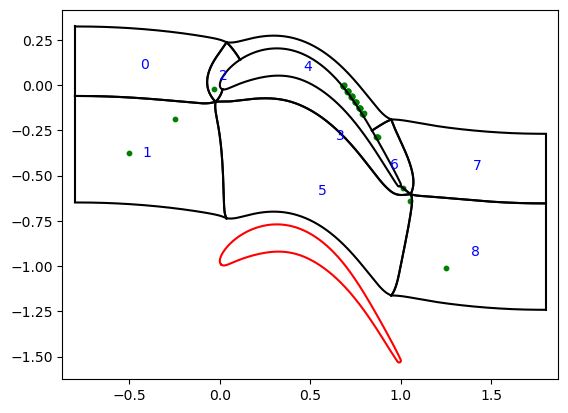

In [9]:
# %matplotlib qt
%matplotlib inline
# unpack case for plotting
blk = case['blk']
# plot profile, topology and mesh
plt.figure(1)
plt.plot(xprof,yprof-pitch,'-r')
plt.axis('equal')
# Extract LE and TE points
iLE = np.argmin(xprof)
iTE = np.argmax(xprof)
xLE = xprof[iLE]
yLE = yprof[iLE]
xTE = xprof[iTE]
yTE = yprof[iTE]
cax = xTE-xLE
for ib in range(len(blk)):
    xnew=blk[ib]['x']
    ynew=blk[ib]['y']
    plt.plot(xnew[0,:],ynew[0,:],'k')
    plt.plot(xnew[-1,:],ynew[-1,:],'k')
    plt.plot(xnew[:,0],ynew[:,0],'k')
    plt.plot(xnew[:,-1],ynew[:,-1],'k')
    # Compute center and add block number
    x_center = np.mean(xnew)
    y_center = np.mean(ynew)
    plt.text(x_center, y_center, str(ib), color='blue', fontsize=10, ha='center', va='center')

for pr in probes:
    plt.scatter(probes.get(pr).get('xc'), probes.get(pr).get('yc'), 10, 'g')
    # print(probes.get(pr).get('xc'),probes.get(pr).get('yc')) 
# plt.axis([0, 1.3, -1, 0.2])
# plt.axis([0.65, 1, -0.6, 0])
plt.show()

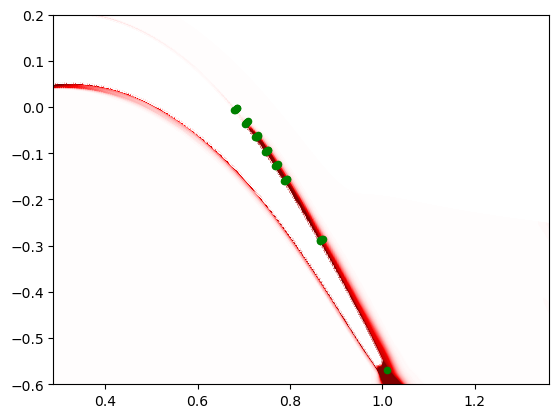

In [195]:
from postpro.read_flo import *
from postpro.read_2d_mean import *
casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug4'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivity\coarsemesh'
# %matplotlib qt
%matplotlib inline
# prop,geom=read_flo(casename)
prop,geom,_=read_2d_mean(casename,[10])
plt.figure(1); plt.axis('equal')
for ib in range(len(geom)):
    x = geom[ib]['x']; y = geom[ib]['y']; f = prop[ib]['vortz']
    # h1 = plt.pcolormesh(x,y,prop[ib]['vortz'][:,:,0],shading='gouraud'); h1.set_clim([-5000, 5000]); plt.set_cmap('seismic') # instantaneous
    h1 = plt.pcolormesh(x,y,prop[ib]['ruu'],shading='gouraud'); h1.set_clim([-1, 1]); plt.set_cmap('seismic') # mean
    # h1 = plt.pcolormesh(x,y,prop[ib]['tu'],shading='gouraud'); h1.set_clim([0, 3]); plt.set_cmap('seismic') # mean
# plt.axis([0, 1.3, -1, 0.2])
plt.axis([0.65, 1, -0.6, 0.2])

for pr in probes:
    plt.scatter(probes.get(pr).get('xc'), probes.get(pr).get('yc'), 20, 'g')

# 3. Assess convergence and flowfield

## Probe and monitor data

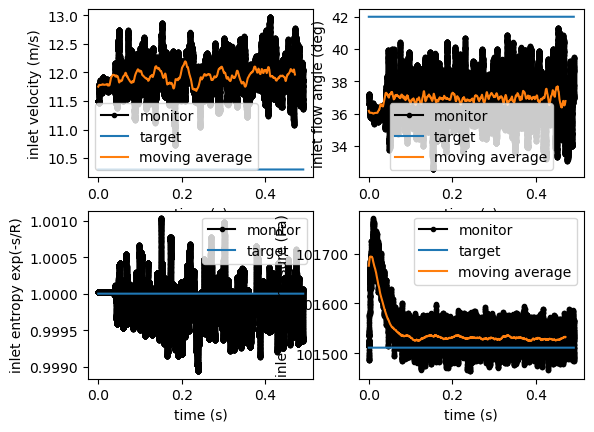

Timesteps = 6160000 ( 6160.0 k)
Inlet velocity = 11.96 m/s (target = 10.3 )
Inlet flow angle = 36.78 deg (target = 42.0 )
Inlet total pressure = 101532.0 Pa (target = 101511.0 )


In [6]:
from postpro.plot_monitor import *

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\NoTurbZero'
casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug19'

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesclean'
casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesturb'

# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'

# %matplotlib qt
%matplotlib inline

prop, target = plot_monitor(casename,2500);

print('Timesteps =', prop['timesteps'], '(', round(prop['timesteps']/1000,0), 'k)')
print('Inlet velocity =', round(prop['lastvel'],2), 'm/s (target =', round(target['vin'][0],2), ')')
print('Inlet flow angle =', round(prop['lastalpha'],2), 'deg (target =', round(target['ain'][0],2), ')')
print('Inlet total pressure =', round(prop['lastpo'],0), 'Pa (target =', round(target['poin'][0],0), ')')

### Read in probe data

Total samples: 616000 , Ranged samples: 504000


<Figure size 640x480 with 0 Axes>

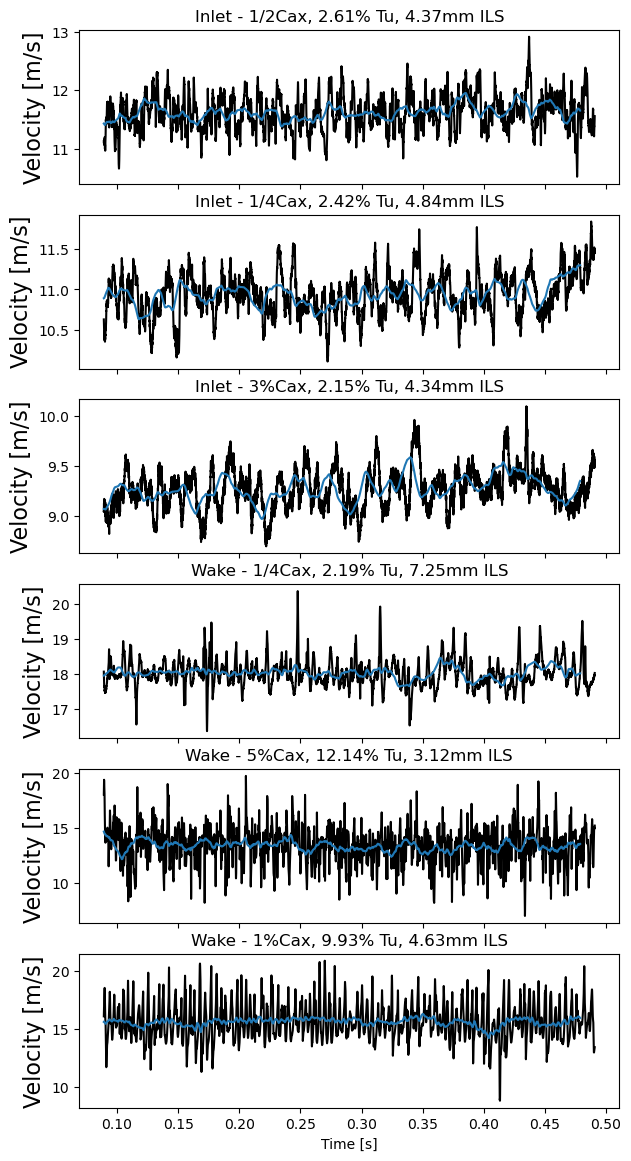

In [9]:
import matplotlib.pyplot as plt
from postpro.read_probe import *
from postpro.process_probe import *
from postpro.process_probe_v2 import *
# import scienceplots

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\NoTurbZero'
casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug19'

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesclean'
casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesturb'

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'

range_start = 0 # to sample all data
# range_start = 80000 # When to start plotting/averaging after, to avoid initial transients. Remember probes every 10 timesteps so really 500k dts
range_start = 112000 # after transients of 1120k timesteps
# range_start = 224000 # after transients of 2240k timesteps

probe = read_probe(casename)
probe_processed = process_probe_v2(casename, probe, range_start, export=True)

print('Total samples:', len(probe[1]['vel']), ', Ranged samples:', len(probe[1]['vel'][range_start:]))

# %matplotlib qt
%matplotlib inline

plt.figure(1)
window_size = 15000 # Moving average window size
weights = np.ones(window_size) / window_size

titles = ['Inlet - 1/2Cax', 'Inlet - 1/4Cax', 'Inlet - 3%Cax', 'Wake - 1/4Cax', 'Wake - 5%Cax', 'Wake - 1%Cax']
# with plt.style.context(['science', 'notebook']):
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(8,14), sharex=True)
for idx,ax in enumerate(axes.flat):
    tempplt = np.convolve(probe[idx]['vel'][range_start:], weights, mode='valid')
    ax.plot(probe[idx]['time'][range_start:],probe[idx]['vel'][range_start:],'-k', probe[idx]['time'][range_start:len(tempplt)+range_start],tempplt)
    ax.set_title(titles[idx] + ', ' + str(probe_processed[idx]['tu']) +'% Tu, ' + str(probe_processed[idx]['ils']) + 'mm ILS')
    if idx==5:
        ax.set_xlabel('Time [s]')
    ax.set_ylabel('Velocity [m/s]', fontsize=16)
fig.subplots_adjust(right=0.8)

plt.show()

### Read in SS BL probes

42


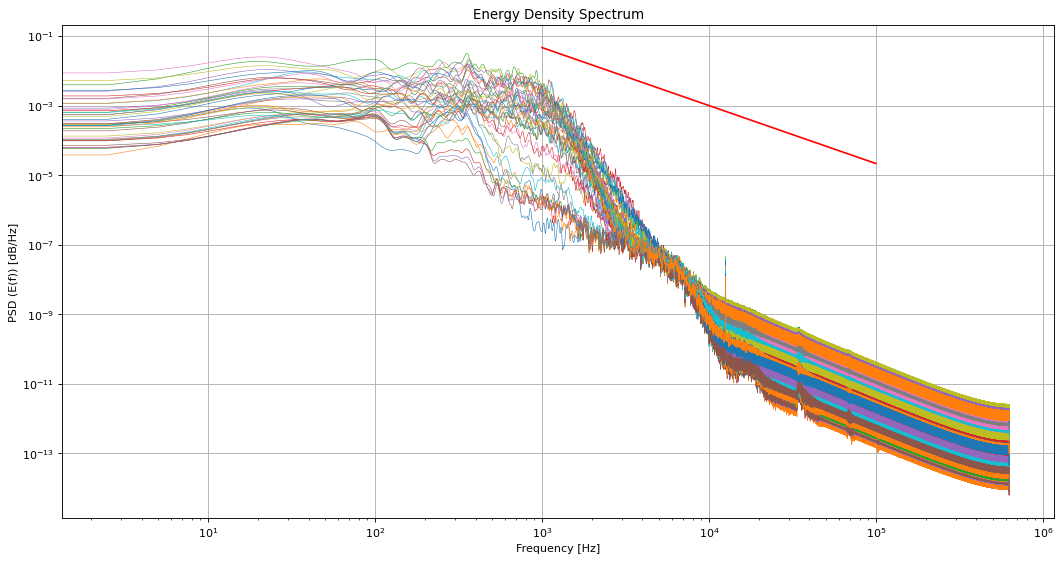

In [16]:
print(len(probe)-6)
plt.figure(1, figsize=(16, 8), dpi=80)

for idx in range(len(probe)-6):
    probe_idx = idx + 6
    plt.loglog(probe[probe_idx]['f2'], probe[probe_idx]['pxx2'], linewidth=0.5)
# probe_idx = 0
# plt.loglog(probe[probe_idx]['aFreq'], probe[probe_idx]['Energy'], linewidth=0.5)
# plt.loglog(probe[probe_idx]['f2'], probe[probe_idx]['pxx2'], linewidth=0.5)
f0 = 10000; psd0 = 0.001; f_slope = np.array([f0 / 10, f0 * 10]); psd_slope = psd0*(f_slope/f0)**(-5/3)
plt.loglog(f_slope, psd_slope, 'r', label='-5/3 slope')
plt.title('Energy Density Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD (E(f)) [dB/Hz]')
plt.grid(True)

## Add turbulence decay

## Check instantaneous flowfield

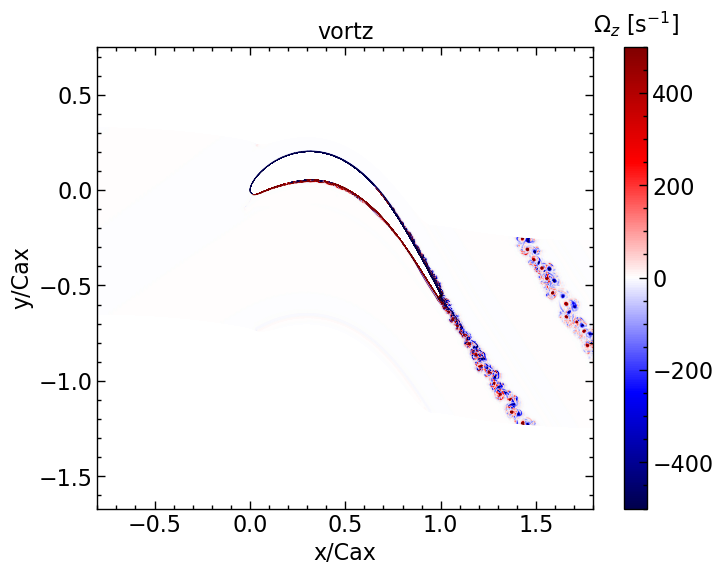

In [3]:
from postpro.read_flo import *
from postpro.plot_flo import *
import scienceplots

# pop-out figure
# %matplotlib qt
%matplotlib inline

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\NoTurbZero'
casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug19'

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesclean'
casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesturb'

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'

# read flo
prop,geom=read_flo(casename)

with plt.style.context(['science', 'notebook']):
    plt.set_cmap('seismic')
    # plot_flo(prop,geom,'w',[-2,2]) # Velocity in Z
    # plot_flo(prop,geom,'vortz',[-15000,15000]) # Vorticity in Z
    plot_flo(prop,geom,'vortz',[-500,500]) # Vorticity in Z
    # plot_flo(prop,geom,'p',[1.01e5,1.016e5]) # Static pressure
    # plot_flo(prop,geom,'po',[1.01e5,1.016e5]) # Total pressure
    # plot_flo(prop,geom,'u',[-5, 25.0]) # Streamwise velocity
    # plot_flo(prop,geom,'alpha',[-70, 40]) # Flow angle
    # plot_flo(prop,geom,'s',[-28.123, -27.396]) # Entropy
    
    # plt.axis([0, 1.3, -1, 0.2])
    # plt.axis([0.65, 1, -0.6, 0])
    # plt.savefig((casename + r"\vortz.png"),dpi=750) 

## Resolution

In [ ]:
from postpro.boundarylayer import *
from postpro.boundarylayer_v2 import *

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\NoTurbZero'
casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug19'

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesclean'
casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesturb'

# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'

bl =boundarylayer_v2(casename,[100]);

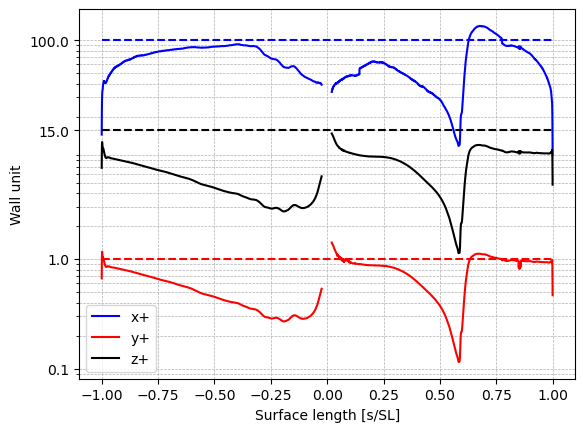

SS Average xplus:  56.4  (Target <15)
SS Average yplus:  0.83  (Target <1)
SS Average zplus:  8.22  (Target <10)
SS Max xplus:  135.08  (Target <15)
SS Max yplus:  1.42  (Target <1)
SS Max zplus:  14.04  (Target <10)


In [25]:
import scienceplots
from matplotlib import ticker
#%matplotlib qt
%matplotlib inline

with plt.style.context(['science', 'notebook']):
    plt.figure(1)
    plt.semilogy(bl['ss']['s']/bl['ss']['s'][-1],bl['ss']['xplus'],'-b')
    plt.semilogy(bl['ss']['s']/bl['ss']['s'][-1],bl['ss']['yplus'],'-r')
    plt.semilogy(bl['ss']['s']/bl['ss']['s'][-1],bl['ss']['zplus'],'-k')
    
    plt.semilogy(-bl['ps']['s']/bl['ps']['s'][-1],bl['ps']['xplus'],'-b')
    plt.semilogy(-bl['ps']['s']/bl['ps']['s'][-1],bl['ps']['yplus'],'-r')
    plt.semilogy(-bl['ps']['s']/bl['ps']['s'][-1],bl['ps']['zplus'],'-k')
    
    # plt.hlines(15, -1, 1, colors='b', linestyles='--') # DNS
    # plt.hlines(1, -1, 1, colors='r', linestyles='--') # DNS
    # plt.hlines(10, -1, 1, colors='k', linestyles='--') # DNS
    
    plt.hlines(100, -1, 1, colors='b', linestyles='--') # LES
    plt.hlines(1, -1, 1, colors='r', linestyles='--') # LES
    plt.hlines(15, -1, 1, colors='k', linestyles='--') # LES
    plt.legend(['x+','y+','z+'])
    plt.xlabel('Surface length [s/SL]')
    plt.ylabel('Wall unit')
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
    locs, labels = plt.yticks()
    # plt.yticks([0.1, 1, 10, 15]) # DNS
    plt.yticks([0.1, 1, 15, 100]) # LES
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.show()
side = 'ss'
print('SS Average xplus: ', np.round(np.average(bl[side]['xplus']),2), ' (Target <15)')
print('SS Average yplus: ', np.round(np.average(bl[side]['yplus']),2), ' (Target <1)')
print('SS Average zplus: ', np.round(np.average(bl[side]['zplus']),2), ' (Target <10)')
print('SS Max xplus: ', np.round(np.max(bl[side]['xplus']),2), ' (Target <15)')
print('SS Max yplus: ', np.round(np.max(bl[side]['yplus']),2), ' (Target <1)')
print('SS Max zplus: ', np.round(np.max(bl[side]['zplus']),2), ' (Target <10)')

## Kolmogorov length scale

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from postpro.plot_flo import *
from postpro.read_2d_mean import *

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesclean'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesturb'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\meds'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\fines'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\vfines'

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug4' # high turb
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug10' # low turb
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug16' # no turb

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivity/finemesh'

# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'

prop,geom,_=read_2d_mean(casename,[40]);

In [ ]:
# import scienceplots
# %matplotlib qt
%matplotlib inline

plt.set_cmap('seismic')

# with plt.style.context(['science', 'notebook']):
# plot the ratio of L_kol to cell size
kol_max = 8 # rule of thumb to set cell lengths to be within 10 Kolmogorov length-scales
plot_flo(prop,geom,'res',[0,kol_max])
# plt.axis([0, 1.3, -1, 0.2]) # whole blade
plt.axis([0.6, 1.0, -0.55, 0]) # SS BL closeup

## Statistical convergence

[11, 11]
[11, 12]
[11, 13]
[11, 14]
[11, 16]
[11, 17]
[11, 18]
[11, 19]
[11, 20]
[11, 21]
[11, 22]
[11, 23]
[11, 24]
[11, 25]
[11, 26]
[11, 27]
[11, 28]
[11, 29]
[11, 30]
[11, 31]
[11, 32]
[11, 33]
[11, 34]
[11, 35]
[11, 36]
[11, 37]
[11, 38]


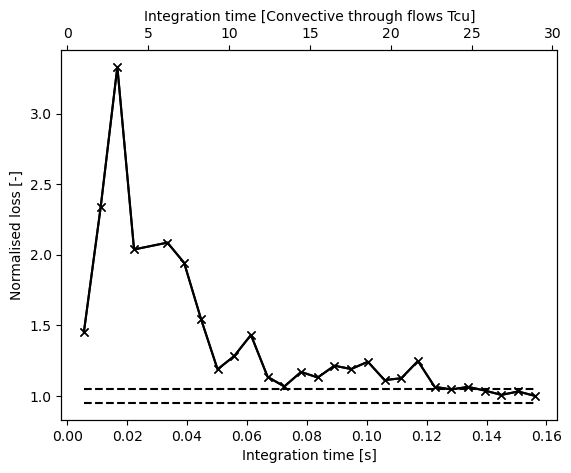

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from postpro.sumvolx import *
from postpro.yp import *
from postpro.read_2d_mean import *
# import scienceplots

# %matplotlib qt
%matplotlib inline

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesclean'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesturb'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\meds'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\fines'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\vfines'

# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug4' # high turb
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug10' # low turb
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug16' # no turb

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'

nmean = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20] # coarsesclean
nmean = [11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38] # coarsesturb
# nmean = [7,8,9,10,11,12,13,14,16,17,18,19,20]
# nmean = [1,2,3,4,5,6,7]

Tcu = 0.0621 / 11.5 # Convective through flow = axial chord / inlet velocity
inlet = {}
exit = {}
inlet['blocks'] = [1,2]
exit['blocks'] = [8,9]
inlet['x']= -0.2 # avoid buffer regions near inlet bc
exit['x'] = 1.2 # avoid buffer regions near exit bc
loss = np.zeros([len(nmean),1]);
integration_time = np.zeros([len(nmean),1]);
for i,n in enumerate(nmean):
    prop,geom,time=read_2d_mean(casename,[nmean[0],nmean[i]]);
    print([nmean[0], nmean[i]])
    perf = yp(prop,geom,inlet,exit);
    loss[i] = perf['yp'];
    integration_time[i] = time;
# with plt.style.context(['science', 'notebook']):
fig, ax1 = plt.subplots()
ax1.set_xlabel('Integration time [s]')
ax1.set_ylabel('Normalised loss [-]')
ax1.plot(integration_time,loss/loss[-1],'-kx')
ax1.plot(integration_time,np.linspace(1.05,1.05,len(nmean)),'--k') # 5%
ax1.plot(integration_time,np.linspace(0.95,0.95,len(nmean)),'--k') # 5%
ax2 = ax1.twiny()
ax2.plot(integration_time/Tcu,loss/loss[-1],'-kx')
ax2.set_xlabel('Integration time [Convective through flows Tcu]')

plt.show()

## Entropy budget

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import scienceplots

from postpro.read_2d_mean import *
from postpro.sumvolx import *

# pop-out figures
#%matplotlib qt
%matplotlib inline

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesclean'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesturb'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\meds'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\fines'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\vfines'

# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug4' # high turb 50.82%
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug10' # low turb 57.12%
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug16' # no turb 57.98%

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivity/medmesh'
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/main/task3noturb'
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/main2short/sdebug4'
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/main2short/sdebug16'

prop,geom,_=read_2d_mean(casename,[40]);

<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\i'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_758584/3630383058.py:18: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(xposlong,resolved_diss_long,'-k',linewidth=3, label='$\phi/T$' )
/tmp/ipykernel_758584/3630383058.py:21: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel('Cumulative $ \int_V f dV $')


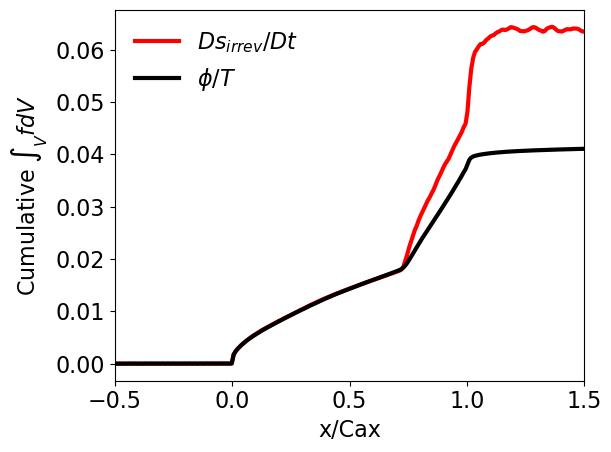

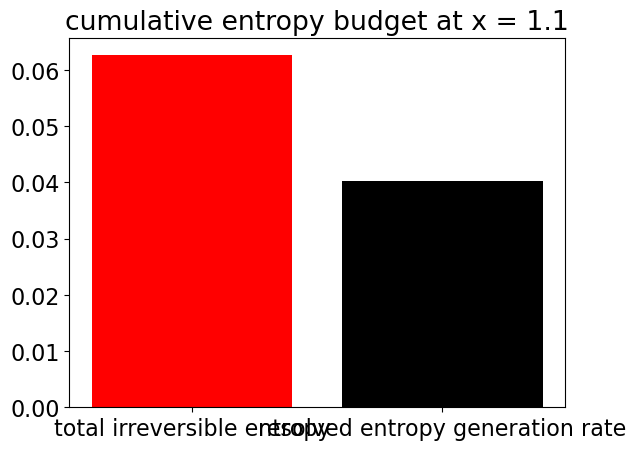

ratio of resolved to total irreversible entropy generation rate = 64.25%


In [19]:
plt.rcParams['font.size'] = '12'
xposlong = np.linspace(-0.5,1.5,250);
xposshort = np.linspace(-0.1,1.1,250);

xpos_req = 1.1
iplot = min(range(len(xposshort)), key=lambda i: abs(xposshort[i]-xpos_req))

irrev_entropy_flux_long  = sumvolx(prop,geom,'Dsi',xposlong);
resolved_diss_long = sumvolx(prop,geom,'dissT',xposlong);
irrev_entropy_flux_short  = sumvolx(prop,geom,'Dsi',xposshort);
resolved_diss_short = sumvolx(prop,geom,'dissT',xposshort);

# with plt.style.context(['science', 'notebook']):
plt.figure(1)
# plt.plot(xposlong,irrev_entropy_flux_long,'-r',linewidth=3, label='$Ds_{irrev}/Dt, \ x=(-0.5,1.5)$')
plt.plot(xposlong,irrev_entropy_flux_long,'-r',linewidth=3, label='$Ds_{irrev}/Dt$')
# plt.plot(xposshort,irrev_entropy_flux_short,'-g',linewidth=3, label='$Ds_{irrev}/Dt, \ x=(-0.1,1.1)$ ')
plt.plot(xposlong,resolved_diss_long,'-k',linewidth=3, label='$\phi/T$' )

plt.xlabel('x/Cax')
plt.ylabel('Cumulative $ \int_V f dV $')
plt.legend(frameon=False)
plt.xlim(-0.5, 1.5)
plt.tight_layout()
plt.savefig((casename + r"/Figures/ResolvedDiss" + str(round(resolved_diss_short[iplot,0]/irrev_entropy_flux_short[iplot,0],2))
             + ".png"),dpi=750, transparent=True) 
plt.show()


plt.figure(2)
plt.bar([0,1],[irrev_entropy_flux_short[iplot,0],resolved_diss_short[iplot,0]], 
        tick_label=['total irreversible entropy','resolved entropy generation rate'],color=['r','k'])
plt.title('cumulative entropy budget at x = '+str(round(xposshort[iplot],2)))
plt.show()

print('ratio of resolved to total irreversible entropy generation rate = ' 
      + str(round(100*resolved_diss_short[iplot,0]/irrev_entropy_flux_short[iplot,0],2)) + '%')

<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_758584/479882943.py:25: SyntaxWarning: invalid escape sequence '\p'
  'Resolved $\phi/T$',


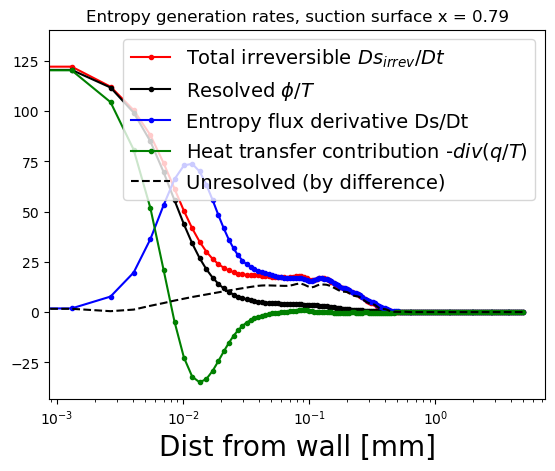

In [8]:
# with plt.style.context(['science', 'notebook']):
# %matplotlib qt
%matplotlib inline
plt.rcParams['font.size'] = '12'
plt.figure(1)
ib = 4 # suction-surface early block

xpos_req = 0.8 # 80% of axial distance
iplot = min(range(len(geom[ib]['x'])), key=lambda i: abs(geom[ib]['x'][i,0]-xpos_req))

x = geom[ib]['x'][iplot,:]
y = geom[ib]['y'][iplot,:]

# distance to wall
cax = 0.06301079
yn = np.sqrt((x-x[-1])**2.0 + (y-y[-1])**2.0) * cax * 1e3

plt.semilogx(yn,prop[ib]['Dsi'][iplot,:],'-r.')
plt.semilogx(yn,prop[ib]['dissT'][iplot,:],'-k.')
plt.semilogx(yn,prop[ib]['Ds'][iplot,:],'-b.')
plt.semilogx(yn,prop[ib]['Dsr'][iplot,:],'-g.')
plt.semilogx(yn,prop[ib]['Dsi'][iplot,:]-prop[ib]['dissT'][iplot,:],'--k')

plt.title('Entropy generation rates, suction surface x = '+str(np.floor(x[0]*100.0)/100))
plt.legend(['Total irreversible $Ds_{irrev}/Dt$',
            'Resolved $\phi/T$',
            'Entropy flux derivative Ds/Dt',
            'Heat transfer contribution -$div(q/T)$',
            'Unresolved (by difference)'], fontsize=14)
plt.xlabel('Dist from wall [mm]',fontsize=20)

plt.savefig((casename + r"/Figures/EntropyBudget_SS_" + str(np.floor(x[0]*100.0)/100) + "xcax.png"),dpi=750, transparent=True) 
plt.show()

## Entropy loss breakdown

Time for coarsesclean : 0.44 mins


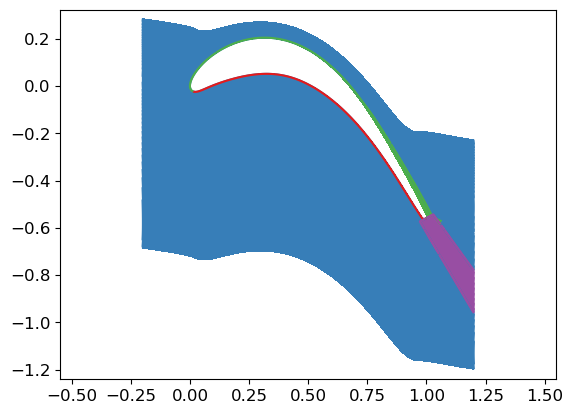

In [65]:
# from postpro.loss_breakdown import *
from postpro.loss_breakdown_MA import *
import timeit
# %matplotlib qt
%matplotlib inline

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/main2short/sdebug4'
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/main2short/sdebug16'

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'
mean_files = 40

start = timeit.default_timer()
# losses,_ = loss_breakdown(casename, mean_files, 'Dsi')
# losses,_ = loss_breakdown(casename, mean_files, "dissT")
losses,losses_MA,_ = loss_breakdown_MA(casename, mean_files, "Dsi")
# losses,losses_MA,_ = loss_breakdown_MA(casename, mean_files, "dissT")
stop = timeit.default_timer()
print('Time for',os.path.basename(casename), ':', round((stop - start)/60,2), 'mins')  

plt.savefig((casename + r"/Figures/LossBreakdownMask.png"),dpi=750, transparent=True) 

### Non-Mass-averaged (total entropy generation: Dsi * mdot, not normalised)

Total: 0.39867 100.0%
PS_BL: 0.01307 3.28%
SS_BL: 0.27248 68.35%
Wake: 0.10541 26.44%
Passage: 0.00771 1.93%


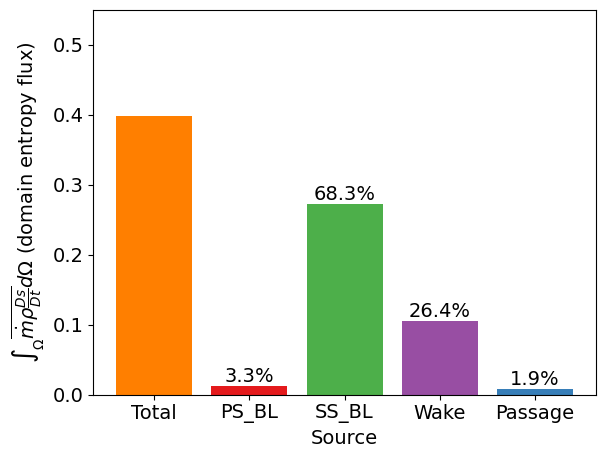

In [67]:
# import scienceplots
import matplotlib.pyplot as plt
# %matplotlib qt
%matplotlib inline
plt.rcParams['font.size'] = '14'
cols=['#e41a1c',
    '#377eb8',
    '#4daf4a',
    '#984ea3',
    '#ff7f00']
cols_order = [4,0,2,3,1]
# with plt.style.context(['science', 'notebook']):

fig, ax = plt.subplots()
i = 0
for name, val in losses.items():
    print(f"{name}: {round(val,5)} {round(100*val/losses['Total'],2)}%")
    percentage = val / losses['Total']        # decimal fraction
    p1 = ax.bar(name, round(val, 3), color=cols[cols_order[i]])
    if name != 'Total':
        # Provide your own labels instead of using fmt
        ax.bar_label(p1, labels=[f"{percentage*100:.1f}%"])
    i += 1
plt.ylabel(r'$\int_\Omega \overline{\dot m \rho \frac{Ds}{Dt}} d\Omega$ (domain entropy flux)')
plt.xlabel('Source')
plt.tight_layout()
plt.ylim(0,0.55)
plt.savefig((casename + r"/Figures/LossBreakdownEntropy.png"),dpi=750, transparent=True) 

### Mass-averaged (to each region. i.e. weighted to amount of mass flow passing through region)
Average entropy generation experienced by a unit mass that passes through that sub-region

Local intensity per unit mass

Total: 5.75117 100.0%
PS_BL: 2.50946 43.63%
SS_BL: 2.89783 50.39%
Wake: 0.34335 5.97%
Passage: 0.00053 0.01%


Text(0.5, 0, 'Source')

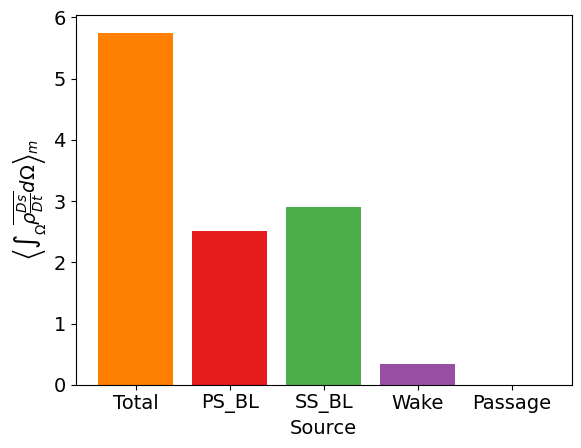

In [68]:
# with plt.style.context(['science', 'notebook']):
plt.figure(1)
i=0
for name,val in losses_MA.items():
    print(f"{name}: {round(val,5)} {round(100*val/losses_MA['Total'],2)}%")
    # plt.bar(name, val/losses['Total'], color=cols[cols_order[i]])
    plt.bar(name, val, color=cols[cols_order[i]])
    i += 1
plt.ylabel(r'$\left\langle \int_\Omega \overline{\rho \frac{Ds}{Dt}} d\Omega \right\rangle_m$')
plt.xlabel('Source')

## Plot mean flow & Wake profile & Loading

In [28]:
import matplotlib.pyplot as plt
import numpy as np

from postpro.read_2d_mean import *
from postpro.sumvolx import *

# pop-out figures
#%matplotlib qt
%matplotlib inline

casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesclean'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\coarsesturb'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\meds'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\fines'
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\meshsensitivityshort\vfines'

# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug4' # high turb 50.82%
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug10' # low turb 57.12%
# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug16' # no turb 57.98%

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/main/task3noturb'
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/main2short/sdebug4'

prop,geom,time=read_2d_mean(casename,[40]);

(0.6, 1.0, -0.6, 0.0)

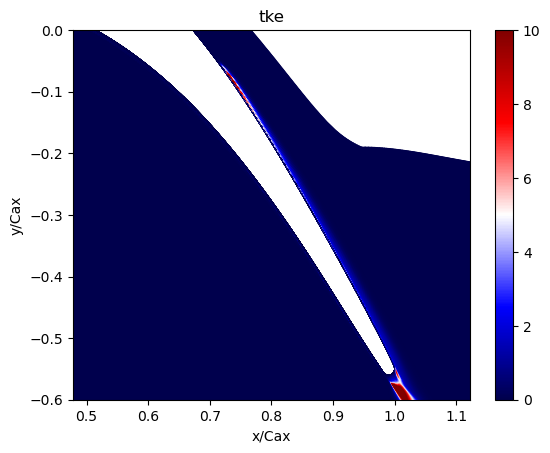

In [9]:
# import scienceplots
from postpro.plot_flo import *
# pop-out figure
# %matplotlib qt
%matplotlib inline

# with plt.style.context(['science', 'notebook']):
plt.set_cmap('seismic')
# plt.set_cmap('jet')
# plt.set_cmap('viridis')

# plot_flo(prop,geom,'po',[1.01e5,1.02e5])
# plot_flo(prop,geom,'w',[-2,2])
# plot_flo(prop,geom,'vortz',[-500,500])
# plot_flo(prop,geom,'p',[1.01e5,1.016e5])
# plot_flo(prop,geom,'u',[-2, 2])
# plot_flo(prop,geom,'tu',[0, 1])
# plot_flo(prop,geom,'mut_opt',[0, 150])
plot_flo(prop,geom,'tke',[0, 10])

# plot_flo(prop,geom,'Dsi',[-0.5, 0.5])
plt.axis([0, 1.3, -1, 0.2])
# plt.savefig((casename + r"/Figures/tke.png"),dpi=750, transparent=True) 
# plt.axis([0.6, 1.0, -0.6, 0])

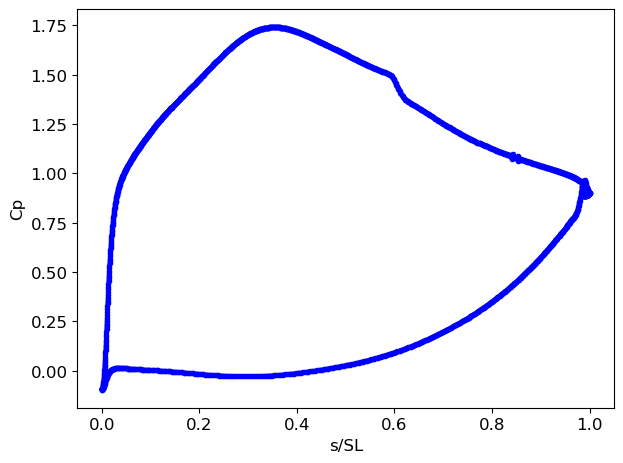

In [29]:
plt.rcParams['font.size'] = '12'
# %matplotlib qt
%matplotlib inline


ss_wall_blocks = [3, 5, 7]
ps_wall_blocks = [4]

P01 = 101511
P2 = 101325

figureCp = plt.figure(2)

# List to store all combined data
combined_data = []

# ss
for i in ss_wall_blocks:
    cp = (P01 - prop[i-1]['p'][:, -1]) / (P01 - P2)
    x = geom[i-1]['x'][:, -1]
    y = geom[i-1]['y'][:, -1]
    s = geom[i-1]['s'] / geom[6]['s'][-1] # Normalised to max surface length
    if i==7:
        cp = cp[::-1]
    
    # Plotting
    plt.plot(s, cp, '-b.', linewidth=3)
    # plt.plot(x, cp, 'b-')
    
    # # Append each (x, cp, block) row to the combined_data list
    for si, cpi in zip(s, cp):
        combined_data.append([si, cpi])
output_file = os.path.join(casename, 'combined_cp_data_ss.csv')
np.savetxt(output_file, combined_data, delimiter=',', header='s,cp', comments='') # Save to CSV

cp = (P01 - prop[ps_wall_blocks[0]-1]['p'][:, -1]) / (P01 - P2)
x = geom[ps_wall_blocks[0]-1]['x'][:, -1]
y = geom[ps_wall_blocks[0]-1]['y'][:, -1]
s = geom[ps_wall_blocks[0]-1]['s'] / geom[ps_wall_blocks[0]-1]['s'][-1] # Normalised to max surface length
combined_data = []
for si, cpi in zip(s, cp):
    combined_data.append([si, cpi])
output_file = os.path.join(casename, 'combined_cp_data_ps.csv')
np.savetxt(output_file, combined_data, delimiter=',', header='s,cp', comments='') # Save to CSV
    
# ps Plotting
plt.plot(s, cp, '-b.', linewidth=3)
# plt.plot(x, cp, 'b-')

# combined_data = np.array(combined_data) # Convert to numpy array

plt.xlabel('s/SL')
plt.ylabel('Cp')
plt.tight_layout()
plt.savefig((casename + r"/Figures/Cp.png"),dpi=750, transparent=True) 
import pickle; file = open((casename + f"/Figures/Cp.mpl"), 'wb'); pickle.dump(figureCp,file)
plt.show()

Yp= 1.067 %
xi= 1.066 %


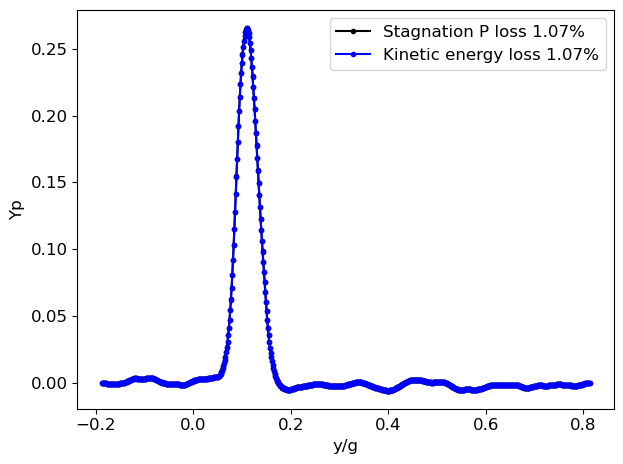

In [30]:
# import scienceplots
from postpro.yp import *
# %matplotlib qt
%matplotlib inline
plt.rcParams['font.size'] = '12'
inlet = {}
exit = {}
combined_data = []
inlet['blocks'] = [1,2]
exit['blocks'] = [8,9]

inlet['x']= -0.5 # avoid buffer regions near inlet bc
exit['x'] = 1.25 # avoid buffer regions near exit bc - Plane 05
# exit['x'] = 1.5 # avoid buffer regions near exit bc - Plane 06

if exit['x']==1.25:
    plane = '05'
else:
    plane = '06'

# with plt.style.context(['science', 'notebook']):
plt.figure(1)
perf = yp(prop,geom,inlet,exit);
wake = perf['wake']
Yp = perf['yp']
xi = perf['xi']
plt.plot(wake['y'],wake['yp'],'-k.',label=f'Stagnation P loss {round(Yp*100,2)}%')
plt.plot(wake['y'],wake['xi'],'-b.',label=f'Kinetic energy loss {round(xi*100,2)}%')
# periodic repeat
# plt.plot(wake['y']-1,wake['yp'],'-k.')
# plt.plot(wake['y']-1,wake['xi'],'-b.')
print('Yp=', round(Yp*100,3), '%') # Stagnation pressure loss coeff
print('xi=', round(xi*100,3), '%') # Kinetic energy loss coeff
plt.xlabel('y/g')
plt.ylabel('Yp')
plt.legend(loc='upper right')
plt.tight_layout()
# plt.axis([-0.5, 0.5, -0.015, 0.3])
plt.savefig((casename + f"/Figures/WakeProfile_plane{plane}_{str(round(xi,4))}.png"),dpi=750, transparent=True) 
import pickle; file = open((casename + f"/Figures/WakeProfile_plane{plane}_{str(round(xi,4))}.mpl"), 'wb'); pickle.dump(figureCp,file)
plt.show()

for yi, xii in zip(wake['y'], wake['xi']):
    combined_data.append([yi, xii])
output_file = casename + r"/Figures/WakeProfile_data_plane" + plane + "_" + str(round(xi,4)) + ".csv"
np.savetxt(output_file, combined_data, delimiter=',', header='y/pitch, xi kinetic energy loss', comments='') # Save to CSV

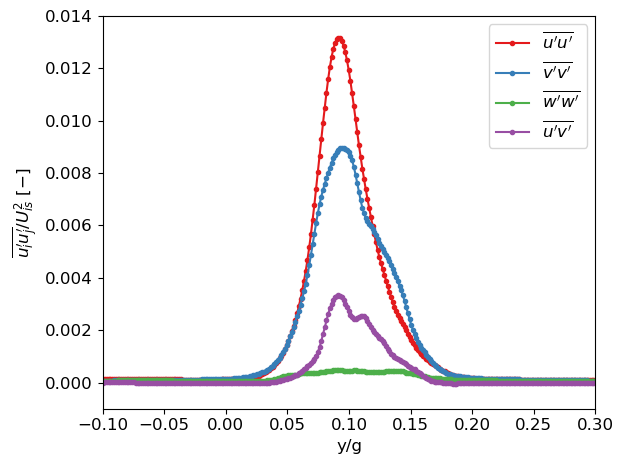

In [31]:
cols=['#e41a1c',
    '#377eb8',
    '#4daf4a',
    '#984ea3',
    '#ff7f00']

Uis = 17

inlet['x']= -0.5 # avoid buffer regions near inlet bc
exit['x'] = 1.25 # avoid buffer regions near exit bc - Plane 05
# exit['x'] = 1.5 # avoid buffer regions near exit bc - Plane 06

figure = plt.figure(1)
perf = yp(prop,geom,inlet,exit);
wake = perf['wake']
ReStress = perf['ReStress']
plt.plot(wake['y'],ReStress['uu']/Uis**2,'.-',color=cols[0],markerfacecolor=cols[0],label=r'$\overline{u^\prime u^\prime}$')
plt.plot(wake['y'],ReStress['vv']/Uis**2,'.-',color=cols[1],markerfacecolor=cols[1],label=r'$\overline{v^\prime v^\prime}$')
plt.plot(wake['y'],ReStress['ww']/Uis**2,'.-',color=cols[2],markerfacecolor=cols[2],label=r'$\overline{w^\prime w^\prime}$')
plt.plot(wake['y'],ReStress['uv']/Uis**2,'.-',color=cols[3],markerfacecolor=cols[3],label=r'$\overline{u^\prime v^\prime}$')
plt.xlabel('y/g')
plt.ylabel(r'$\overline{u_i^\prime u_j^\prime}/U_{is}^2 \ [-]$')
plt.legend(loc='upper right')
if exit['x']==1.25:
    plane = '05'
    plt.axis([-0.1, 0.3, -0.001, 0.014])
else:
    plane = '06'
    plt.axis([0.9, 1.3, -0.001, 0.014])
plt.tight_layout()
plt.savefig((casename + f"/Figures/ReStressProfile_plane{plane}.png"),dpi=750, transparent=True) 
import pickle; file = open((casename + f"/Figures/ReStressProfile_plane{plane}.mpl"), 'wb'); pickle.dump(figure,file)
plt.show()

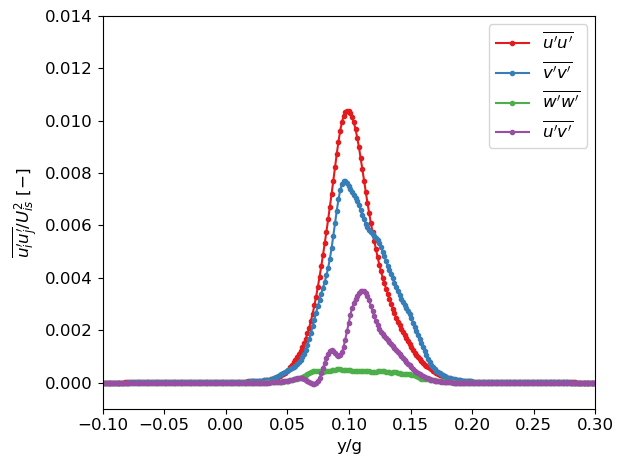

(array([-1.87311735e-01, -1.85816132e-01, -1.84320785e-01, -1.82825705e-01,
        -1.81330901e-01, -1.79836381e-01, -1.78342153e-01, -1.76848225e-01,
        -1.75354605e-01, -1.73861300e-01, -1.72368317e-01, -1.70875661e-01,
        -1.69383339e-01, -1.67891357e-01, -1.66399718e-01, -1.64908428e-01,
        -1.63417491e-01, -1.61926912e-01, -1.60436693e-01, -1.58946838e-01,
        -1.57457351e-01, -1.55968233e-01, -1.54479487e-01, -1.52991115e-01,
        -1.51503119e-01, -1.50015501e-01, -1.48528261e-01, -1.47041402e-01,
        -1.45554924e-01, -1.44068828e-01, -1.42583114e-01, -1.41097783e-01,
        -1.39612835e-01, -1.38128272e-01, -1.36644092e-01, -1.35160296e-01,
        -1.33676885e-01, -1.32193858e-01, -1.30711215e-01, -1.29228956e-01,
        -1.27747082e-01, -1.26265593e-01, -1.24784488e-01, -1.23303768e-01,
        -1.21823433e-01, -1.20343483e-01, -1.18863919e-01, -1.17384741e-01,
        -1.15905950e-01, -1.14427546e-01, -1.12949531e-01, -1.11471905e-01,
        -1.0

In [2]:
from postpro.show_fig_from_pickle import *
%matplotlib inline
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
plane = '05'
filename = casename + r"/Figures/ReStressProfile_plane" + plane + ".mpl"
fig_handle = show_fig_from_pickle(filename)

fig_handle.axes[0].lines[0].get_data()

## Loading and Cf comp to Argo

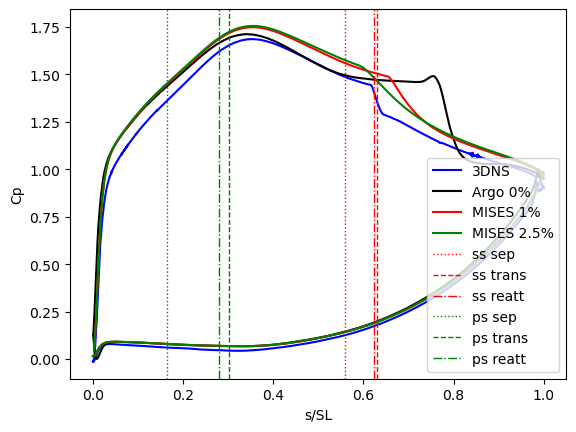

/gpfs/softs/easybuild/2024a/software/Anaconda3/2024.06-1/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/gpfs/softs/easybuild/2024a/software/Anaconda3/2024.06-1/lib/python3.12/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/gpfs/softs/easybuild/2024a/software/Anaconda3/2024.06-1/lib/python3.12/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/gpfs/softs/easybuild/2024a/software/Anaconda3/2024.06-1/lib/python3.12/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


(-0.01, 0.03)

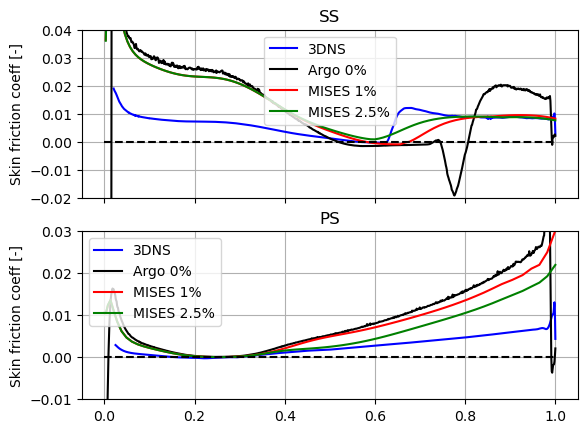

In [10]:
import csv  # for CSV writing
import os
from postpro.read_2d_mean import *
from postpro.boundarylayer_v2 import *
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots

filenames = ['Cp_ZeroInc_SS', 'Cp_ZeroInc_PS', 'Cf_ZeroInc_SS', 'Cf_ZeroInc_PS',
            'MISES1.0_Cf_ZeroInc_PS','MISES1.0_Cf_ZeroInc_SS','MISES2.5_Cf_ZeroInc_PS','MISES2.5_Cf_ZeroInc_SS',
            'MISES1.0_Cp_ZeroInc_PS','MISES1.0_Cp_ZeroInc_SS','MISES2.5_Cp_ZeroInc_PS','MISES2.5_Cp_ZeroInc_SS'
            ]
data = {}  # dictionary to hold all CSV data
base_path = '/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/LoadingCf_Argo/'
for casename in filenames:
    new_filename = os.path.join(base_path, casename + '.csv')
    df = pd.read_csv(new_filename, header=None)
    data[casename] = df

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/main2short/sdebug4' # high turb
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/main2short/sdebug10' # low turb
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/main2short/sdebug16' # no turb

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'

prop,geom,_=read_2d_mean(casename,[20])

sep_trans = {"trans_ss_grad":0, "trans_ss_midp":0, "trans_ps_grad":0, "trans_ps_midp":0, "sep_ss":0, "reatt_ss":0, "sep_ps":0, "reatt_ps":0}
for key,value in sep_trans.items():
    sep_trans[key] = pd.read_csv(os.path.join(casename, key + '.csv'))['s/SL'].item()

output_file = os.path.join(casename, 'combined_cp_data.csv')

# %matplotlib qt
%matplotlib inline

ss_wall_blocks = [3, 5, 7]
ps_wall_blocks = [4]

P01 = 101511
P2 = 101325

with plt.style.context(['science', 'notebook']):
    plt.figure(1)
    
    # List to store all combined data
    combined_data = []
    # ss
    for i in ss_wall_blocks:
        cp = (P01 - prop[i-1]['p'][:, -1]) / (P01 - P2)
        x = geom[i-1]['x'][:, -1]
        y = geom[i-1]['y'][:, -1]
        s = geom[i-1]['s'] / geom[6]['s'][-1] # Normalised to max surface length
        if i==7:
            cp = cp[::-1]
        # Plotting
        plt.plot(s, cp, 'b-')
        
        # # Append each (x, cp, block) row to the combined_data list
        for si, cpi in zip(s, cp):
            combined_data.append([si, cpi, i])
    
    cp = (P01 - prop[ps_wall_blocks[0]-1]['p'][:, -1]) / (P01 - P2)
    x = geom[ps_wall_blocks[0]-1]['x'][:, -1]
    y = geom[ps_wall_blocks[0]-1]['y'][:, -1]
    s = geom[ps_wall_blocks[0]-1]['s'] / geom[ps_wall_blocks[0]-1]['s'][-1] # Normalised to max surface length
    for si, cpi in zip(s, cp):
        combined_data.append([si, cpi, i])
        
    # ps Plotting
    plt.plot(s, cp, 'b-', label='3DNS')
    # combined_data = np.array(combined_data) # Convert to numpy array
    np.savetxt(output_file, combined_data, delimiter=',', header='s,cp,block', comments='') # Save to CSV
    
    plt.plot(data['Cp_ZeroInc_SS'][0], data['Cp_ZeroInc_SS'][1], 'k-', label='Argo 0%')
    plt.plot(data['Cp_ZeroInc_PS'][0], data['Cp_ZeroInc_PS'][1], 'k-')
    
    plt.plot(data['MISES1.0_Cp_ZeroInc_SS'][0], data['MISES1.0_Cp_ZeroInc_SS'][1], 'r-', label='MISES 1%')
    plt.plot(data['MISES1.0_Cp_ZeroInc_PS'][0], data['MISES1.0_Cp_ZeroInc_PS'][1], 'r-')
    plt.plot(data['MISES2.5_Cp_ZeroInc_SS'][0], data['MISES2.5_Cp_ZeroInc_SS'][1], 'g-', label='MISES 2.5%')
    plt.plot(data['MISES2.5_Cp_ZeroInc_PS'][0], data['MISES2.5_Cp_ZeroInc_PS'][1], 'g-')
    
    plt.axvline(sep_trans['sep_ss'], color='r', linestyle='dotted', linewidth=1,label='ss sep')
    plt.axvline(sep_trans['trans_ss_grad'], color='r', linestyle='dashed', linewidth=1,label='ss trans')
    plt.axvline(sep_trans['reatt_ss'], color='r', linestyle='dashdot', linewidth=1,label='ss reatt')
    
    plt.axvline(sep_trans['sep_ps'], color='g', linestyle='dotted', linewidth=1,label='ps sep')
    plt.axvline(sep_trans['trans_ps_grad'], color='g', linestyle='dashed', linewidth=1,label='ps trans')
    plt.axvline(sep_trans['reatt_ps'], color='g', linestyle='dashdot', linewidth=1,label='ps reatt')
    
    plt.legend(loc='lower right')
    plt.xlabel('s/SL')
    plt.ylabel('Cp')
    plt.show()
    
    bl =boundarylayer_v2(casename,[100]); # if statistics accumulation
    fig1, (ax, ax1) = plt.subplots(nrows=2, sharex=True)
    ax.plot(bl['ss']['s']/bl['ss']['s'][-1],bl['ss']['cf'],'b-', label='3DNS')
    ax.plot(data['Cf_ZeroInc_SS'][0], data['Cf_ZeroInc_SS'][1], 'k-', label='Argo 0%')
    ax.plot(data['MISES1.0_Cf_ZeroInc_SS'][0], data['MISES1.0_Cf_ZeroInc_SS'][1], 'r-', label='MISES 1%')
    ax.plot(data['MISES2.5_Cf_ZeroInc_SS'][0], data['MISES2.5_Cf_ZeroInc_SS'][1], 'g-', label='MISES 2.5%')
    ax.hlines(0, 0, 1, 'k', linestyle='dashed')
    ax.set_ylabel('Skin friction coeff [-]');
    ax.grid(which='both')
    ax.set_title('SS')
    ax.legend()
    ax.set_ylim(-0.02, 0.04)
    
    ax1.plot(bl['ps']['s']/bl['ps']['s'][-1],bl['ps']['cf'],'b-', label='3DNS')
    ax1.plot(data['Cf_ZeroInc_PS'][0], data['Cf_ZeroInc_PS'][1], 'k-', label='Argo 0%')
    ax1.plot(data['MISES1.0_Cf_ZeroInc_PS'][0], data['MISES1.0_Cf_ZeroInc_PS'][1], 'r-', label='MISES 1%')
    ax1.plot(data['MISES2.5_Cf_ZeroInc_PS'][0], data['MISES2.5_Cf_ZeroInc_PS'][1], 'g-', label='MISES 2.5%')
    ax1.hlines(0, 0, 1, 'k', linestyle='dashed')
    ax1.set_ylabel('Skin friction coeff [-]');
    ax1.grid(which='both')
    ax1.set_title('PS')
    ax1.legend()
    ax1.set_ylim(-0.01, 0.03)

# 4. BL analysis

In [32]:
from postpro.boundarylayer import *
from postpro.boundarylayer_v2 import *

# casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main\debug5'
casename = r'C:\Users\cassidy\OneDrive - vki.ac.be\Documents\Technical\CAD and CFD\desktop-dns-main\outputs\main2short\sdebug4'

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/main2short/sdebug4' # High turb
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/main2short/sdebug16' # No turb

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'

# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivity/finemesh'

# bl = boundarylayer_v2(casename); # if no statistics accumulation yet

bl =boundarylayer_v2(casename,[100]); # if statistics accumulation

### Debugging BL thickness

1020


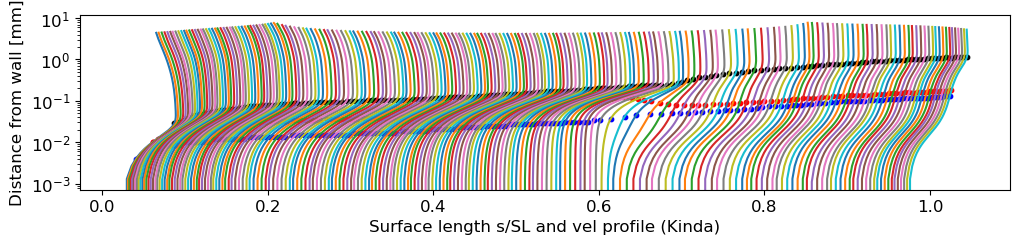

In [33]:
# %matplotlib qt
%matplotlib inline
plt.rcParams['font.size'] = '12'
side = 'ss'
# side = 'ps'

s = bl[side]['s']/bl[side]['s'][-1]
r = bl[side]['r_profile']
v = bl[side]['vel_profile']
N = len(bl[side]['r_profile'])
print(N)

# with plt.style.context(['science', 'notebook']):
figure = plt.figure(1, figsize=(12,4))

start_i = 10
end_i = int(0.95 * N)
n_samples = 200
for i in np.linspace(start_i,end_i-1,n_samples,dtype='int'):
    factor = 250 # to flatten or widen velocity profiles
    vel = (bl[side]['vel_profile'][i,:]-bl[side]['vel_profile'][i,0])/factor + s[i]
    r = bl[side]['r_profile'][i,:]*0.06301079*1e3
    plt.semilogy(vel,r)
    # plt.plot(vel,r)

    d99 = bl[side]['d0'][i]*0.06301079*1e3
    dstar = bl[side]['d1'][i]*0.06301079*1e3
    theta = bl[side]['d2'][i]*0.06301079*1e3
    d99i = min(range(len(r)), key=lambda i: abs(r[i]-d99))
    dstari = min(range(len(r)), key=lambda i: abs(r[i]-dstar))
    thetai = min(range(len(r)), key=lambda i: abs(r[i]-theta))
    plt.scatter(vel[d99i], r[d99i], 10, color='k')
    plt.scatter(vel[dstari], r[dstari], 10, color='r')
    plt.scatter(vel[thetai], r[thetai], 10, color='b')

plt.gca().set_aspect(0.05)
# plt.ylim([0, 1])
plt.xlabel('Surface length s/SL and vel profile (Kinda)')
plt.ylabel('Distance from wall [mm]')
plt.savefig((casename + f"/Figures/VelProfilesDebug_{side}.png"),dpi=750, transparent=True) 
import pickle; file = open((casename + f"/Figures/VelProfilesDebug_{side}.mpl"), 'wb'); pickle.dump(figure,file)

## Find transition/separation/location points

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from postpro.compute_transition import compute_transition, compute_sep_reatt

sides = ['ss', 'ps']
results = {}

for side in sides:
    s = bl[side]['s']
    H = bl[side]['H']
    Cf = bl[side]['cf']
    trans_grad, trans_midp = compute_transition(s, H)
    results[f"trans_{side}_grad"] = trans_grad
    results[f"trans_{side}_midp"] = trans_midp

    sep_loc, reatt_loc = compute_sep_reatt(s, Cf)
    results[f"sep_{side}"] = sep_loc
    results[f"reatt_{side}"] = reatt_loc
    
    print(f"{side.upper()} -> tr_grad: {trans_grad:.4f}, tr_midp: {trans_midp:.4f}, sep: {sep_loc:.4f}, reatt: {reatt_loc:.4f}")

# --- Export each result to separate CSV file ---
for key, value in results.items():
    df = pd.DataFrame({'s/SL': [value]})
    df.to_csv(os.path.join(casename, f"{key}.csv"), index=False)
    print(f"Saved {key}.csv")

print("✅ Transition, Separation, and Reattachment locations exported successfully.")

## Cf

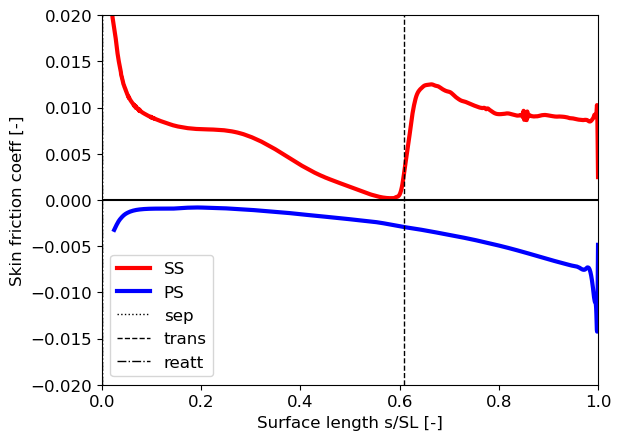

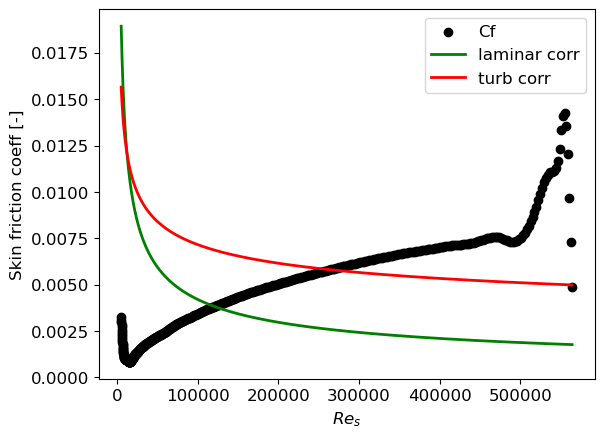

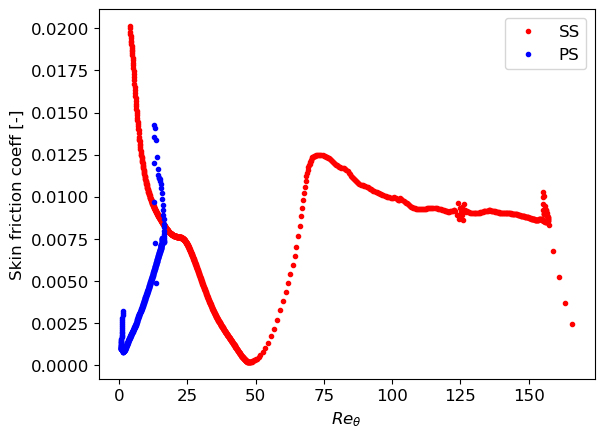

In [34]:
import csv  # for CSV writing
import os
import pandas as pd
# import scienceplots
# import matplotlib as mpl

#%matplotlib qt
%matplotlib inline

plt.rcParams['font.size'] = '12'

sep_trans = {"trans_ss_grad":0, "trans_ss_midp":0, "trans_ps_grad":0, "trans_ps_midp":0, "sep_ss":0, "reatt_ss":0, "sep_ps":0, "reatt_ps":0}
for key,value in sep_trans.items():
    sep_trans[key] = pd.read_csv(os.path.join(casename, key + '.csv'))['s/SL'].item()

# with plt.style.context(['science', 'notebook']):
figureCf = plt.figure(1)
plt.plot(bl['ss']['s']/bl['ss']['s'][-1],bl['ss']['cf'],'r',linewidth=3, label='SS')
plt.plot(bl['ps']['s']/bl['ps']['s'][-1],-bl['ps']['cf'],'b',linewidth=3, label='PS')
# plt.plot(bl['ss']['x'],bl['ss']['cf'],'r.')
# plt.plot(bl['ps']['x'],-bl['ps']['cf'],'b.')
side = 'ss'
plt.axvline(sep_trans['sep_' + side], color='k', linestyle='dotted', linewidth=1,label='sep')
plt.axvline(sep_trans['trans_' + side + '_grad'], color='k', linestyle='dashed', linewidth=1,label='trans')
plt.axvline(sep_trans['reatt_' + side], color='k', linestyle='dashdot', linewidth=1,label='reatt')
plt.hlines(0, 0, 1, 'k')
plt.legend()
plt.xlabel('Surface length s/SL [-]')
plt.ylabel('Skin friction coeff [-]')
# plt.axis([0, 1, -0.002, 0.008]) # For Cf using calculated ro and U
# plt.axis([0, 1, -0.008, 0.008]) # For Cf using calculated ro and U
plt.axis([0, 1, -0.02, 0.02]) # For Cf using constant ro and U
# mpl.rcParams['text.usetex'] = True
plt.savefig((casename + r"/Figures/Cf.png"),dpi=750, transparent=True) 
import pickle; file = open((casename + f"/Figures/Cf.mpl"), 'wb'); pickle.dump(figureCf,file)
plt.show()
output_file = os.path.join(casename, 'combined_cf_data_ss.csv')
s = bl['ss']['s']/bl['ss']['s'][-1]
cf = bl['ss']['cf']
combined_data = []
for si, cfi in zip(s, cf):
    combined_data.append([si, cfi])
# combined_data = np.array(combined_data) # Convert to numpy array
np.savetxt(output_file, combined_data, delimiter=',', header='s,cf', comments='') # Save to CSV
output_file = os.path.join(casename, 'combined_cf_data_ps.csv')
s = bl['ps']['s']/bl['ps']['s'][-1]
cf = bl['ps']['cf']
combined_data = []
for si, cfi in zip(s, cf):
    combined_data.append([si, cfi])
# combined_data = np.array(combined_data) # Convert to numpy array
np.savetxt(output_file, combined_data, delimiter=',', header='s,cf', comments='') # Save to CSV

side = 'ss'
# side = 'ps'
cax = 0.06301079
output_file = os.path.join(casename, side + '_cf.csv')
output_data = []
for si, cfi in zip(bl[side]['s']/bl[side]['s'][-1], bl[side]['cf']): output_data.append([si, cfi])
np.savetxt(output_file, output_data, delimiter=',',header='s,cf',comments='')

# with plt.style.context(['science', 'notebook']):
side = 'ss'
side = 'ps'
plt.figure(2)
Res = bl[side]['Res']
cf = bl[side]['cf']
s = bl[side]['s']/bl[side]['s'][-1]
# Correlations from Drela flight vehicle dynamics pg 89 eqs 4.105 4.106
cf_lam = 1.328 / Res**(0.5)
cf_turb = 0.455 / (np.log10(Res))**2.58
plt.scatter(Res,cf, c='k')
plt.plot(Res, cf_lam, 'g', linewidth='2')
plt.plot(Res, cf_turb, 'r', linewidth='2')
plt.xlabel(r'$Re_{s}$')
plt.ylabel('Skin friction coeff [-]')
plt.legend(['Cf', 'laminar corr', 'turb corr'], loc='upper right')
plt.show()

# with plt.style.context(['science', 'notebook']):
plt.figure(3)
plt.plot(bl['ss']['Retheta']*cax,bl['ss']['cf'],'r.')
plt.plot(bl['ps']['Retheta']*cax,bl['ps']['cf'],'b.')
plt.legend(['SS', 'PS'])
plt.xlabel(r'$Re_{\theta}$')
plt.ylabel('Skin friction coeff [-]')
# plt.axis([0, 1, -0.002, 0.008])
# plt.axis([0, 1, -0.008, 0.008])
# mpl.rcParams['text.usetex'] = True
plt.show()

### Correlations (needs work!!)

/tmp/ipykernel_2457498/3718974398.py:25: RuntimeWarning: invalid value encountered in power
  cf_turb = 0.0056 * Retheta**(-1/6)


(0.0, 0.016)

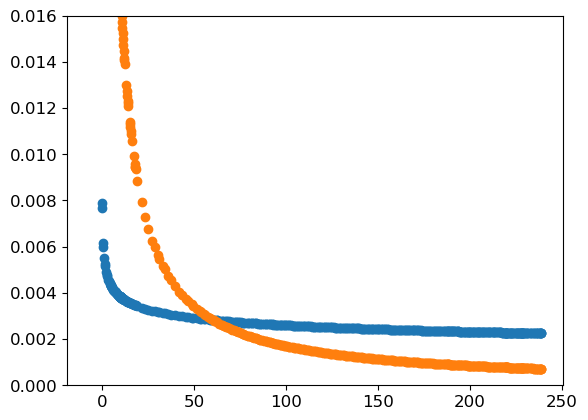

In [37]:
# %matplotlib qt
%matplotlib inline

side = 'ss'
side = 'ps'


# Drela Flight Vehicle Dynamics Equation 4.100 correlation for equilibrium-flow Cd

# Not sure this is strictly correct. The expression is apparently a function of H,Retheta , and yet requires H*, cf, H, and two coefficients A,B
# So which values of H*, cf, H are to be used to get the turbulent correlation? Using the values from the sims is non-sensical as they
# are transitional and also include a non-equilibrium region....

# apparently Denton gave correlations in loss mechanisms!!! Wtf, implement here pls xx

cf = bl[side]['cf']
H = bl[side]['d1']/bl[side]['d2']
Hstar = bl[side]['d3']/bl[side]['d2']
s = bl[side]['s']/bl[side]['s'][-1]
Retheta = bl[side]['Retheta']
A = 6.7
B = 0.75

# Cd_corr = Hstar/2 * (cf/2*(1 - (H-1)/(B * H)) + 1/(A**2 * B) * ((H-1)/H) **3)
cf_turb = 0.0056 * Retheta**(-1/6)
cf_lam = 0.17 * Retheta**(-1)

plt.figure(1)
plt.scatter(Retheta, cf_turb)
plt.scatter(Retheta, cf_lam)
plt.ylim(0, 0.016)

## Integral parameters (add output of thicknesses/shape factor at trailing edge and at separation/transition)

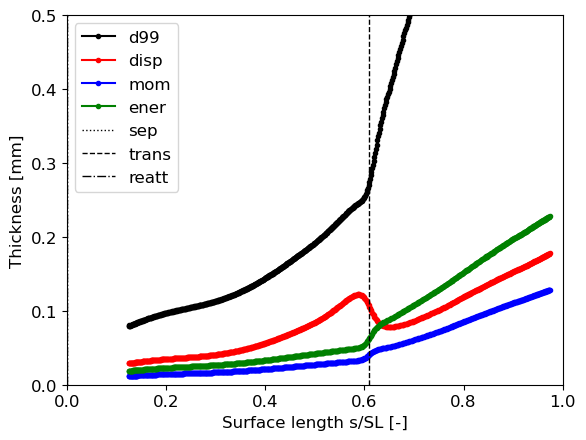

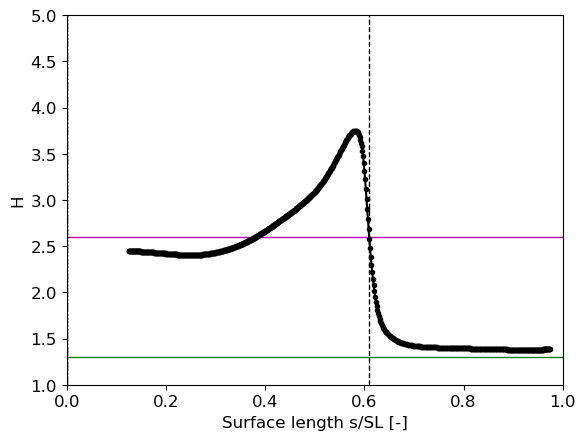

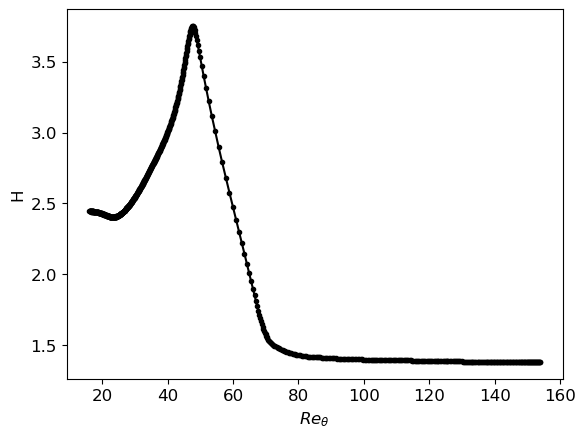

In [35]:
# import scienceplots
# %matplotlib qt
%matplotlib inline
plt.rcParams['font.size'] = '12'
sep_trans = {"trans_ss_grad":0, "trans_ss_midp":0, "trans_ps_grad":0, "trans_ps_midp":0, "sep_ss":0, "reatt_ss":0, "sep_ps":0, "reatt_ps":0}
for key,value in sep_trans.items():
    sep_trans[key] = pd.read_csv(os.path.join(casename, key + '.csv'))['s/SL'].item()

cax = 0.06301079

side = 'ss'
# side = 'ps'

N = len(bl[side]['x'])
start_i = int(0.18 * N)
end_i = int(0.95 * N)

s = bl[side]['s'][start_i:end_i]/bl[side]['s'][-1]
delta = bl[side]['d0'][start_i:end_i]*cax*1e3
disp = bl[side]['d1'][start_i:end_i]*cax*1e3
mom = bl[side]['d2'][start_i:end_i]*cax*1e3
ener = bl[side]['d3'][start_i:end_i]*cax*1e3
H = bl[side]['H'][start_i:end_i]
Retheta = bl[side]['Retheta'][start_i:end_i]*cax

# with plt.style.context(['science', 'notebook']):
figureThick = plt.figure(1)
plt.plot(s,delta,'k.-', label='d99') # delta99
plt.plot(s,disp,'r.-', label='disp') # disp
plt.plot(s,mom,'b.-', label='mom') # mom
plt.plot(s,ener,'g.-', label='ener') # energy
plt.axvline(sep_trans['sep_' + side], color='k', linestyle='dotted', linewidth=1,label='sep')
plt.axvline(sep_trans['trans_' + side + '_grad'], color='k', linestyle='dashed', linewidth=1,label='trans')
plt.axvline(sep_trans['reatt_' + side], color='k', linestyle='dashdot', linewidth=1,label='reatt')
plt.ylim(0,0.5)
plt.legend(loc='upper left')
plt.xlim(0,1)
plt.xlabel('Surface length s/SL [-]')
plt.ylabel('Thickness [mm]')
plt.axis([0, 1, 0, 0.5])
plt.savefig((casename + f"/Figures/BLThicknesses_{side}.png"),dpi=750, transparent=True) 
import pickle; file = open((casename + f"/Figures/BLThicknesses_{side}.mpl"), 'wb'); pickle.dump(figureThick,file)
plt.show()

output_file = os.path.join(casename, side + '_bl.csv')
output_data = []
for si, deli, dispi, momi, eneri, Hi in zip(s, delta, disp, mom, ener, H): output_data.append([si, deli, dispi, momi, eneri, Hi])
np.savetxt(output_file, output_data, delimiter=',',header='s,delta,disp,mom,ener,H',comments='')

# with plt.style.context(['science', 'notebook']):
figureH = plt.figure(2)
plt.hlines(2.6, 0,1, 'm', linewidth=1)
plt.hlines(1.3, 0,1, 'g', linewidth=1)
plt.plot(s,H,'k.-') # Shape factor
plt.axvline(sep_trans['sep_' + side], color='k', linestyle='dotted', linewidth=1,label='sep')
plt.axvline(sep_trans['trans_' + side + '_grad'], color='k', linestyle='dashed', linewidth=1,label='trans')
plt.axvline(sep_trans['reatt_' + side], color='k', linestyle='dashdot', linewidth=1,label='reatt')
plt.xlabel('Surface length s/SL [-]')
plt.ylabel('H')
plt.axis([0, 1, 1, 5])
plt.savefig((casename + f"/Figures/H_{side}.png"),dpi=750, transparent=True) 
import pickle; file = open((casename + f"/Figures/H_{side}.mpl"), 'wb'); pickle.dump(figureH,file)
plt.show()

# with plt.style.context(['science', 'notebook']):
plt.figure(3)
plt.plot(Retheta,H,'k.-') # Shape factor vs momentum Reynolds number
plt.xlabel(r'$Re_{\theta}$')
plt.ylabel('H')
plt.show()

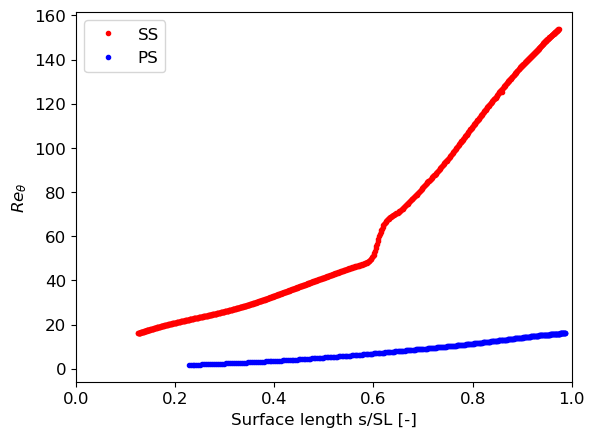

In [36]:
# import scienceplots
# %matplotlib qt
%matplotlib inline

cax = 0.06301079

side = 'ss'
# side = 'ps'

N_SS = len(bl['ss']['x'])
start_i_SS = int(0.18 * N_SS)
end_i_SS = int(0.95 * N_SS)
s_SS = bl['ss']['s'][start_i_SS:end_i_SS]/bl['ss']['s'][-1]
Retheta_SS = bl['ss']['Retheta'][start_i_SS:end_i_SS]*cax
Retau_SS = bl['ss']['Retau'][start_i_SS:end_i_SS]*cax

N_PS = len(bl['ps']['x'])
start_i_PS = int(0.18 * N_PS)
end_i_PS = int(0.95 * N_PS)
s_PS = bl['ps']['s'][start_i_PS:end_i_PS]/bl['ps']['s'][-1]
Retheta_PS = bl['ps']['Retheta'][start_i_PS:end_i_PS]*cax
Retau_PS = bl['ps']['Retau'][start_i_PS:end_i_PS]*cax


# with plt.style.context(['science', 'notebook']):
figureReTheta = plt.figure(1)
plt.plot(s_SS,Retheta_SS,'r.') # Momentum thickness Reynolds number
plt.plot(s_PS,Retheta_PS,'b.') # Momentum thickness Reynolds number
# plt.plot(s,Retau,'k.') # Friction Reynolds number
# plt.ylim(0,0.5)

plt.xlim(0,1)
plt.xlabel('Surface length s/SL [-]')
plt.ylabel(r'$Re_{\theta} $')
plt.legend(['SS', 'PS'], loc='upper left')
plt.savefig((casename + f"/Figures/ReTheta.png"),dpi=750, transparent=True) 
import pickle; file = open((casename + f"/Figures/ReTheta.mpl"), 'wb'); pickle.dump(figureReTheta,file)
plt.show()

## Turbulence production and dissipation: non-equilibrium
Across transition, turb production rises – reaches peak where flow becomes fully turb and falls back to equilibrium
Dissipation also rises across transition, but lags the production – downstream of transition exists region where they’re out of balance (delay between turb structures forming and dissipating)

/gpfs/softs/easybuild/2024a/software/Anaconda3/2024.06-1/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/gpfs/softs/easybuild/2024a/software/Anaconda3/2024.06-1/lib/python3.12/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/gpfs/softs/easybuild/2024a/software/Anaconda3/2024.06-1/lib/python3.12/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/gpfs/softs/easybuild/2024a/software/Anaconda3/2024.06-1/lib/python3.12/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


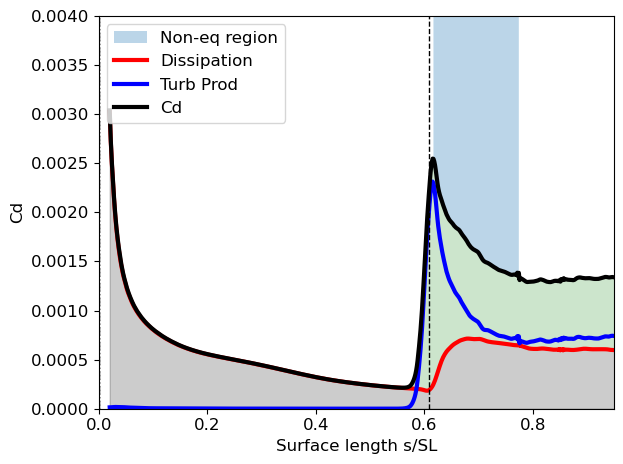

In [37]:
# import scienceplots
# %matplotlib qt
%matplotlib inline

plt.rcParams['font.size'] = '12'

# d9 = Dissipation due to mean strain - normalised to 1/Ue^3
# d10 = Turbulence production - normalised to 1/Ue^3
# d11 = dissipation coefficient

side = 'ss'
# side = 'ps'

## Code to find non-equilibrium region
from scipy.interpolate import splrep, splev
Pr = bl[side]['d10']
x = bl[side]['x']
s = bl[side]['s']/bl[side]['s'][-1]
start = int(0.5 * len(s))
end = int(0.9* len(s))
window_size = 20 # Moving average window size
weights = np.ones(window_size) / window_size
dPrds = np.gradient(Pr, s)
dPrds_smoothed = np.convolve(dPrds[start:end], weights, mode='valid')
zero_crossings = np.where(np.diff(np.signbit(dPrds_smoothed)))[0]
noneq_start_s = s[start+np.argmax(Pr[start:end])]
temp = s[start+zero_crossings]>noneq_start_s # Find zero crossings after peak Pr
noneq_end_s = s[start+zero_crossings[np.where(temp==True)[0][0]]] # Get index of first zero crossing after peak Pr then get x coord


# Define variables from bl data
H = bl[side]['d1']/bl[side]['d2']
Cd = bl[side]['d9']+bl[side]['d10']


# with plt.style.context(['science', 'notebook']):
figureTurb = plt.figure(1)

plt.fill_between(s, Cd, 0.005, where=((s<noneq_end_s) & (s>noneq_start_s)), alpha=0.3)

plt.plot(s,bl[side]['d9'],'-r',linewidth=3) # Diss
plt.plot(s,bl[side]['d10'],'-b',linewidth=3) # Turb
plt.plot(s,Cd,'-k',linewidth=3) # Cd

# plt.plot(bl[side]['s'],Pr_eq)

plt.legend(['Non-eq region','Dissipation','Turb Prod', 'Cd'],loc='upper left')



plt.axvline(sep_trans['sep_' + side], color='k', linestyle='dotted', linewidth=1,label='sep')
plt.axvline(sep_trans['trans_' + side + '_grad'], color='k', linestyle='dashed', linewidth=1,label='trans')
plt.axvline(sep_trans['reatt_' + side], color='k', linestyle='dashdot', linewidth=1,label='reatt')

plt.fill_between(s, bl[side]['d9'], color='k',alpha=0.2)
plt.fill_between(s, bl[side]['d9'], Cd, color='g',alpha=0.2)

plt.xlim(0,0.95)
plt.ylim(0,0.004)
plt.ylabel('Cd')
# plt.xlabel('Axial distance x/Cax')
plt.xlabel('Surface length s/SL')
plt.tight_layout()
plt.savefig((casename + f"/Figures/TurbProdDissipation_{side}.png"),dpi=750, transparent=True) 
import pickle; file = open((casename + f"/Figures/TurbProdDissipation_{side}.mpl"), 'wb'); pickle.dump(figureTurb,file)
plt.show()


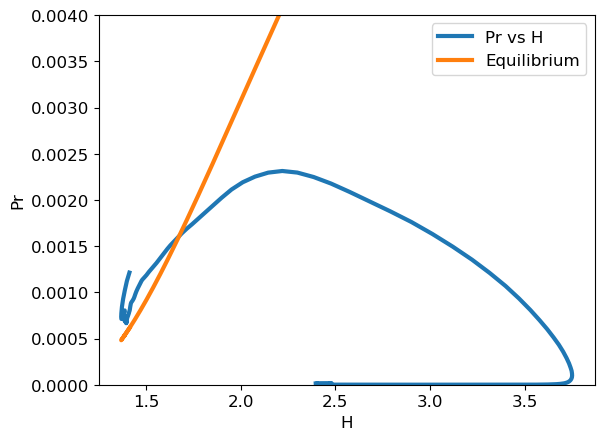

In [38]:
# import scienceplots
plt.rcParams['font.size'] = '12'
# %matplotlib qt
%matplotlib inline

# with plt.style.context(['science', 'notebook']):
figureEq = plt.figure(1)
Pr_eq = 0.02456 * ((H-1)/H)**3 # equilibrium correlation (depends only on shape factor) from Coles and Hurst
plt.plot(H,bl[side]['d10'],linewidth=3)
plt.plot(H,Pr_eq,linewidth=3)
plt.xlabel('H')
plt.ylabel('Pr')

plt.legend(['Pr vs H', 'Equilibrium'])
plt.ylim(0, 0.004)
plt.savefig((casename + f"/Figures/TurbProdVsShapeFactor_{side}.png"),dpi=750, transparent=True) 
import pickle; file = open((casename + f"/Figures/TurbProdDissipation_{side}.mpl"), 'wb'); pickle.dump(figureEq,file)
plt.show()

### Quantify end of noneq region

408
0.13933169571877124


Text(0, 0.5, 'dPr/ds')

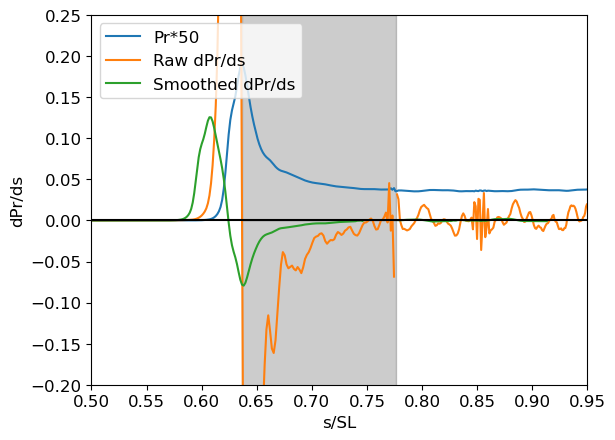

In [29]:
from scipy.interpolate import splrep, splev
# import scienceplots
# %matplotlib qt
%matplotlib inline

Pr = bl[side]['d10']
s = bl[side]['s']/bl[side]['s'][-1]

N = len(s)
start = int(0.5 * N)
end = int(0.9* N)
print(len(s[start:end]))

window_size = 20 # Moving average window size
weights = np.ones(window_size) / window_size
Pr_smoothed = np.convolve(Pr[start:end], weights, mode='valid')

dPrds = np.gradient(Pr, s)
dPrds_smoothed = np.convolve(dPrds[start:end], weights, mode='valid')

zero_crossings = np.where(np.diff(np.signbit(dPrds_smoothed)))[0]
noneq_start_s = s[start+np.argmax(Pr[start:end])]
temp = s[start+zero_crossings]>noneq_start_s # Find zero crossings after peak Pr
noneq_end_s = s[start+zero_crossings[np.where(temp==True)[0][0]]] # Get index of first zero crossing after peak Pr then get x coord
print(noneq_end_s-noneq_start_s)

# with plt.style.context(['science', 'notebook']):
plt.figure(1)

plt.plot(s, Pr*50)
plt.plot(s, dPrds*5)
plt.plot(s[start:len(dPrds_smoothed)+start], dPrds_smoothed)

plt.legend(['Pr*50','Raw dPr/ds', 'Smoothed dPr/ds'], loc='upper left')

plt.fill_between([noneq_start_s, noneq_end_s], [0.25, 0.25], color='k', alpha=0.2)
plt.fill_between([noneq_start_s, noneq_end_s], [-0.25, -0.25], color='k', alpha=0.2)

plt.hlines(0, 0, 0.95, color='k')

plt.xlim(0.5, 0.95)
plt.ylim(-0.2, 0.25)

# plt.xlabel('Axial distance x/Cax')
plt.xlabel('s/SL')
plt.ylabel('dPr/ds')

## Law of the wall

804 0.8005461692479257


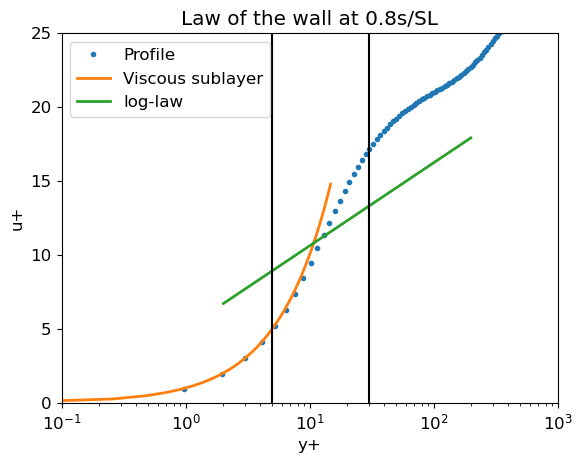

In [39]:
# %matplotlib qt
%matplotlib inline
plt.rcParams['font.size'] = '12'

side = 'ss'
s = bl[side]['s']/bl[side]['s'][-1]

spos_req = 0.8 # 80% along suction side length
iplot = min(range(len(s)), key=lambda i: abs(s[i]-spos_req))
print(iplot, s[iplot])


yplus_theory = np.linspace(-20,200,1000)
uplus_theory = np.linspace(0,11,1000)
kappa = 0.41 # von Karman constant
B = 5.0 # empirical
uviscous = yplus_theory[yplus_theory<=15] # viscous sublayer (y+<=5)
uloglaw = (1/kappa) * np.log(yplus_theory[yplus_theory>2]) + B # log-law region (y+>30)

# with plt.style.context(['science', 'notebook']):
figureLOTW = plt.figure(1)
plt.semilogx(bl[side]['yplus_profile'][iplot,:],bl[side]['uplus_profile'][iplot,:], '.')
plt.semilogx(uviscous, uviscous, linewidth=2)
plt.semilogx(yplus_theory[yplus_theory>2], uloglaw, linewidth=2)


plt.vlines(5,-10,60, color='k')
plt.vlines(30,-10,60, color='k')
plt.xlabel('y+')
plt.ylabel('u+')

plt.xlim(1e-1, 1e3)
# plt.xlim(1e-1, 10)
plt.ylim(0,25)
plt.title(f'Law of the wall at {spos_req}s/SL')
plt.legend(['Profile', 'Viscous sublayer', 'log-law'],loc='upper left')
# plt.grid(which='both',axis='both')
plt.savefig((casename + f"/Figures/LawOfTheWall_{side}_{spos_req}.png"),dpi=750, transparent=True) 
import pickle; file = open((casename + f"/Figures/LawOfTheWall_{side}_{spos_req}.mpl"), 'wb'); pickle.dump(figureLOTW,file)

## Acceleration and Beta parameters

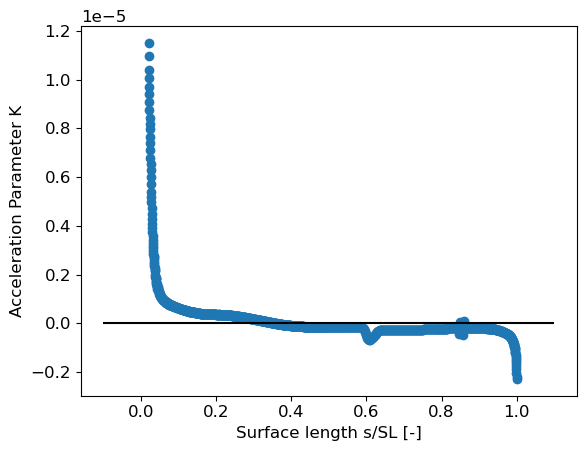

In [40]:
# import scienceplots
# %matplotlib qt
%matplotlib inline
plt.rcParams['font.size'] = '12'
side = 'ss'
# side = 'ps'

# with plt.style.context(['science', 'notebook']):
figureK = plt.figure(1)
beta = bl[side]['beta']
K = bl[side]['K']
Retau = bl[side]['Retau']
s = bl[side]['s']/bl[side]['s'][-1]

plt.scatter(s,K)
plt.hlines(0,-0.1,1.1,'k')
plt.xlabel('Surface length s/SL [-]')
plt.ylabel('Acceleration Parameter K')
plt.savefig((casename + f"/Figures/AccelerationParam_{side}.png"),dpi=750, transparent=True)
import pickle; file = open((casename + f"/Figures/AccelerationParam_{side}.mpl"), 'wb'); pickle.dump(figureK,file)

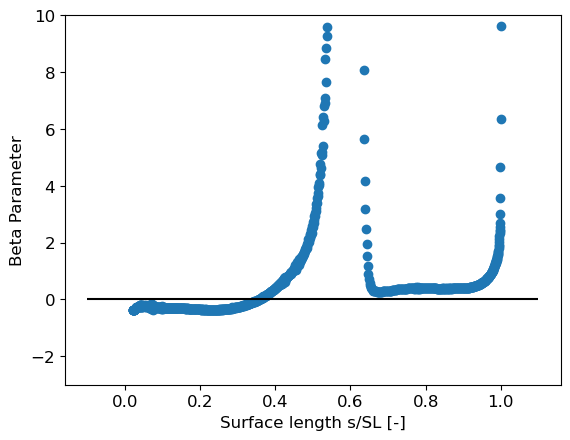

In [55]:
# import scienceplots
# %matplotlib qt
%matplotlib inline
plt.rcParams['font.size'] = '12'
side = 'ss'
# side = 'ps'

# with plt.style.context(['science', 'notebook']):
plt.figure(1)
beta = bl[side]['beta']
K = bl[side]['K']
Retau = bl[side]['Retau']
s = bl[side]['s']/bl[side]['s'][-1]

plt.scatter(s,beta)
plt.hlines(0,-0.1,1.1,'k')
plt.xlabel('Surface length s/SL [-]')
plt.ylabel('Beta Parameter')
plt.ylim(-3,10)
plt.savefig((casename + f"/Figures/BetaParam_{side}.png"),dpi=750, transparent=True)

# 5. POD analysis

### Domain-aligned frame

In [51]:
from postpro.POD_v3 import *

blocks = [2,4,6]
blocks = [4,6] # nothing interesting in 2 and sometimes it contains NaNs
# blocks = [3] # PS
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivity/fine'
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'
# nfiles = [100]
nfiles = [560]
# nfiles = [1120]
dt = 2500 * 8e-8

POD3 = POD_v3(casename, nfiles, blocks, dt, savedata=False, transform_grid=False)



Starting POD analysis (Transform Grid: False)
Reading 560 snapshots...
Data loading complete.
Skipping Grid Transformation. Keeping data in Domain Frame.
... 'x_plot' and 'y_plot' set to physical coordinates.
Preparation complete. Starting POD...
Calculating Correlation matrix C...
Calculating Eigendecomposition...
Calculating POD spatial modes...
Calculating TKE production terms...
Script finished.


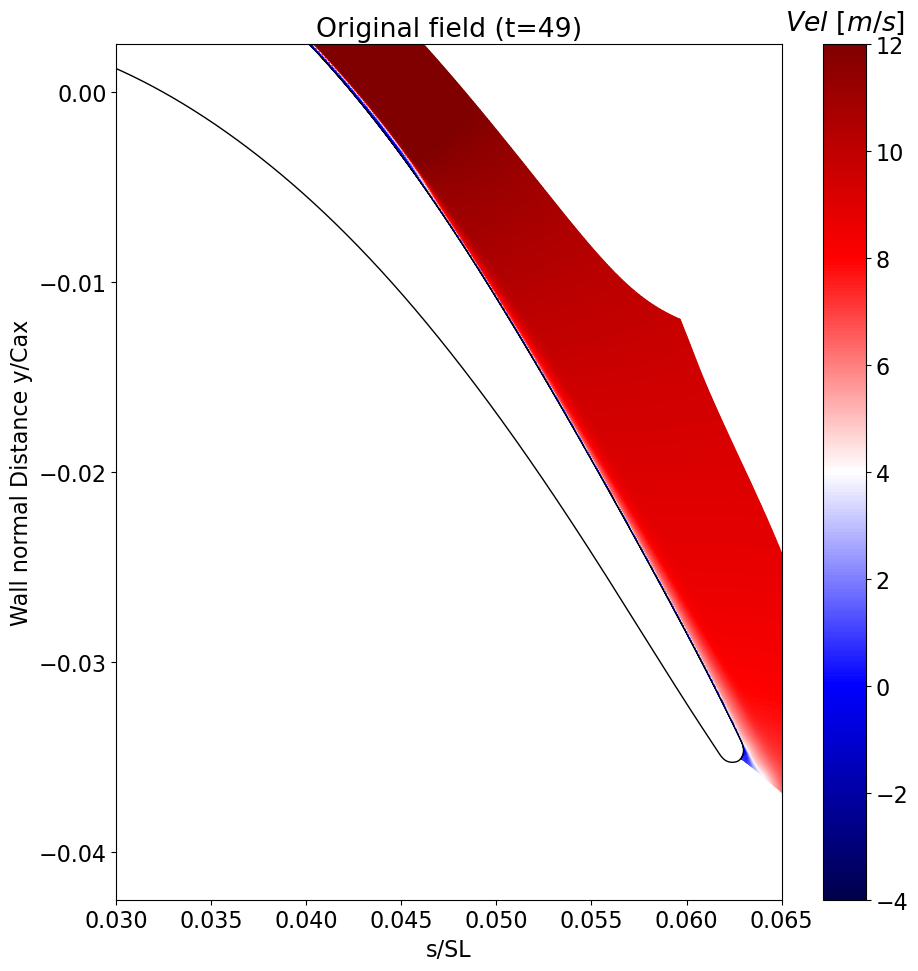

In [71]:
# Time snapshot
t_idx = 49
# t_idx = 500

plt.rcParams['font.size'] = '16'

fig,ax = plt.subplots(figsize=(10,10))
plt.set_cmap('seismic')

clim = [-1,1]
clim = [0,1]
clim = [4,12]
clim = [-4,12]

plot_data = POD3['MU'].reshape(POD3['Nx'], POD3['Ny'], order='F')
# plot_data = POD3['MV'].reshape(POD3['Nx'], POD3['Ny'], order='F')
# plot_data = POD['Up'][:,t_idx].reshape(POD['Nx'], POD['Ny'], order='F')
# plot_data = POD['uRMS'].reshape(POD['Nx'], POD['Ny'], order='F')
# plot_data = POD['vRMS'].reshape(POD['Nx'], POD['Ny'], order='F')

plt.plot(POD3['x_prof']*0.063, POD3['y_prof']*0.063, 'k', linewidth=1)
im = plt.pcolormesh(POD3['x_plot'], POD3['y_plot'], plot_data, shading='gouraud')
# plt.streamplot(x_plot, y_plot, MU.reshape(Nx, Ny, order='F'), MV.reshape(Nx, Ny, order='F'), broken_streamlines=False)
# plt.quiver(POD3['x_plot'], POD3['y_plot'], POD3['MU'].reshape(POD3['Nx'], POD3['Ny'], order='F'), POD3['MV'].reshape(POD3['Nx'], POD3['Ny'], order='F'))
im.set_clim(clim)
plt.title(f'Original field (t={t_idx})')
plt.ylabel('Wall normal Distance y/Cax')
plt.xlabel('s/SL')
# plt.axis([0.4, 0.95, 0, 0.003])
cbar = fig.colorbar(im, ax=ax, location='right')
cbar.ax.set_title(r"$Vel \ [m/s]$", pad=10)
ax.set_ylabel('Wall normal Distance y/Cax')
ax.set_xlabel('s/SL')
# ax.legend(loc='upper left')
plt.axis('equal')
plt.axis([0.03, 0.065, -0.04, 0])
plt.tight_layout()

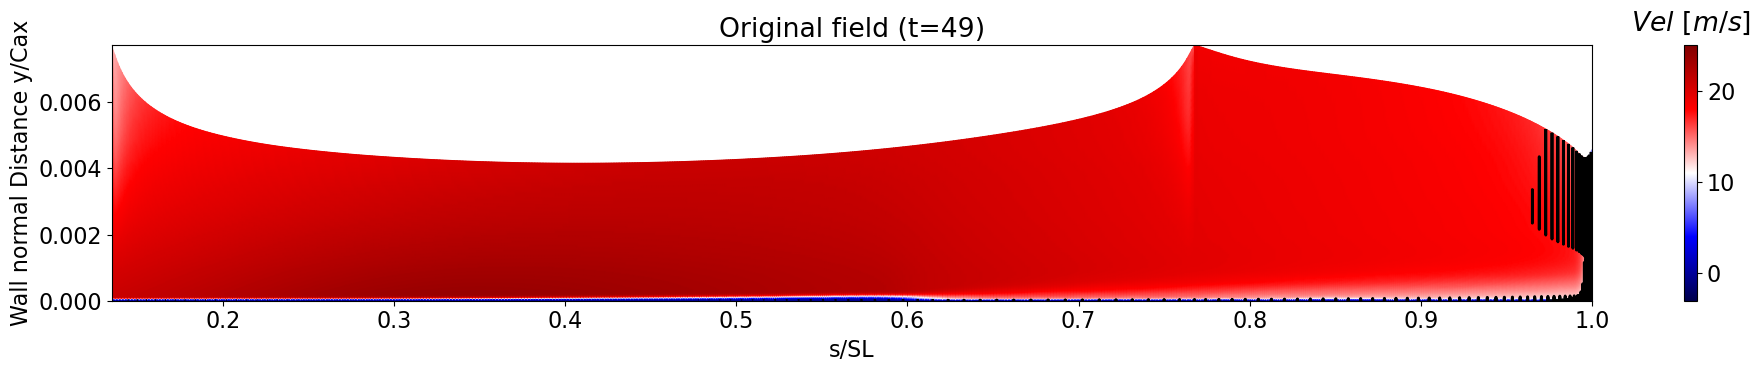

In [74]:
# Time snapshot
t_idx = 49
# t_idx = 500

plt.rcParams['font.size'] = '16'

fig,ax = plt.subplots(figsize=(20,4))
plt.set_cmap('seismic')

clim = [-1,1]
# clim = [-10,10]
# clim = [4,12]
clim = [-3,25]
# clim = [0,25]
# clim = [-0.1,0.1]

plot_data = POD['MU'].reshape(POD['Nx'], POD['Ny'], order='F')
# plot_data = POD['Up'][:,t_idx].reshape(POD['Nx'], POD['Ny'], order='F')
# plot_data = POD['uRMS'].reshape(POD['Nx'], POD['Ny'], order='F')
# plot_data = POD['vRMS'].reshape(POD['Nx'], POD['Ny'], order='F')


im = plt.pcolormesh(POD['x_plot'], POD['y_plot'], plot_data, shading='gouraud')
# plt.streamplot(x_plot, y_plot, MU.reshape(Nx, Ny, order='F'), MV.reshape(Nx, Ny, order='F'), broken_streamlines=False)
# plt.quiver(POD['x_plot'], POD['y_plot'], POD['MU'].reshape(POD['Nx'], POD['Ny'], order='F'), POD['MV'].reshape(POD['Nx'], POD['Ny'], order='F'))
im.set_clim(clim)
plt.contour(POD['x_plot'], POD['y_plot'], POD['MU'].reshape(POD['Nx'], POD['Ny']), levels=[-1,0,1], colors='k', linewidths=2)
plt.title(f'Original field (t={t_idx})')
plt.ylabel('Wall normal Distance y/Cax')
plt.xlabel('s/SL')
# plt.axis([0.4, 0.95, -0.00005, 0.001])
cbar = fig.colorbar(im, ax=ax, location='right')
cbar.ax.set_title(r"$Vel \ [m/s]$", pad=10)
ax.set_ylabel('Wall normal Distance y/Cax')
ax.set_xlabel('s/SL')
# ax.legend(loc='upper left')
plt.tight_layout()

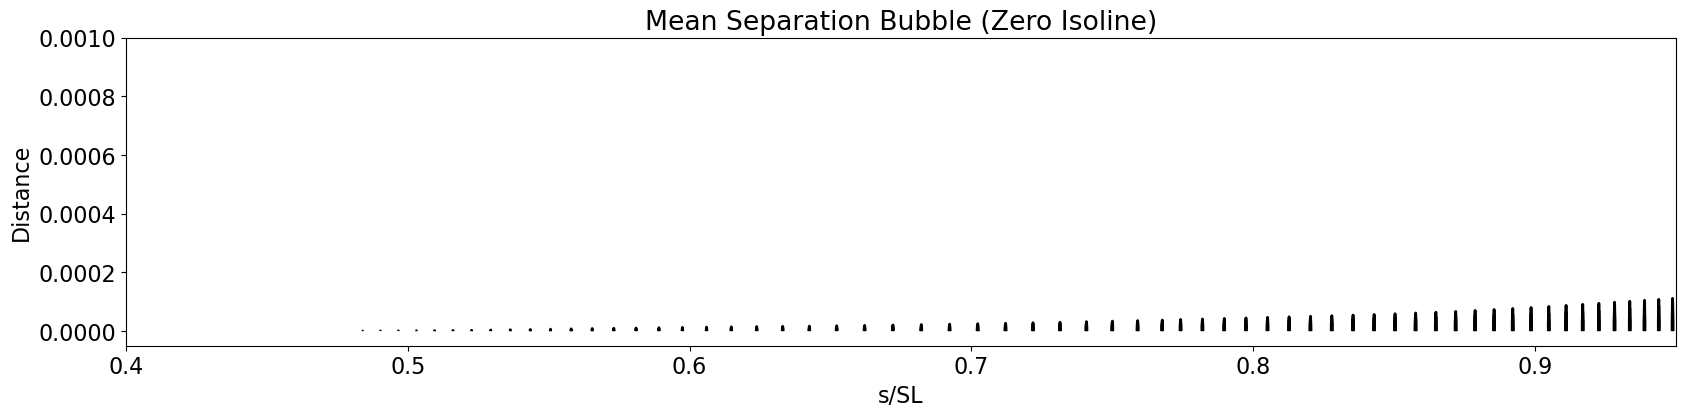

In [41]:
fig,ax = plt.subplots(figsize=(20,4))
plt.contour(POD['x_plot'], POD['y_plot'], POD['MU'].reshape(POD['Nx'], POD['Ny']), levels=[-1,0,1], colors='k', linewidths=2)
plt.xlabel('s/SL')
plt.ylabel('Distance')
plt.title('Mean Separation Bubble (Zero Isoline)')
plt.axis([0.4, 0.95, -0.00005, 0.001])
plt.show()

### Grid-aligned frame main analysis

In [72]:
from postpro.POD_v2 import *
from postpro.POD_v3 import *

blocks = [2,4,6]
blocks = [4,6] # nothing interesting in 2 and sometimes it contains NaNs
# blocks = [3] # PS
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'
nfiles = [560]
# nfiles = [100]
# nfiles = [1120]
dt = 2500 * 8e-8
# casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivity/finemesh'
# nfiles = [160]
# dt = 7000 * 8e-8
# savedata = True
POD = POD_v3(casename, nfiles, blocks, dt, savedata=False, transform_grid=True) # flow in grid-aligned frame

Starting POD analysis (Transform Grid: True)
Reading 560 snapshots...
Data loading complete.
Calculating grid transformation (Grid Aligned)...
Applying transformation to all velocity snapshots...
Creating new rectangular 'box' grid for calculation...
Creating new physical 'plotting' grid (x_plot, y_plot)...
... 'x_plot' and 'y_plot' created for plotting (s/SL and Dist).
Preparation complete. Starting POD...
Calculating Correlation matrix C...
Calculating Eigendecomposition...
Calculating POD spatial modes...
Calculating TKE production terms...
Script finished.

Saving data for animation script...
... Data successfully saved to 'animation_data.npz'.


### Sum of POD modes

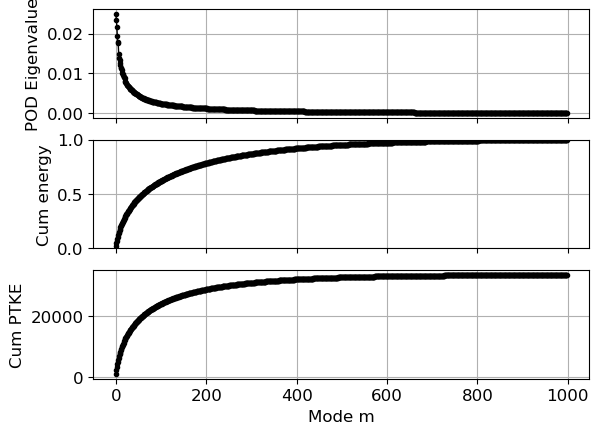

In [105]:
# %matplotlib qt
%matplotlib inline
plt.rcParams['font.size'] = '12'
limit = 1000
if limit>POD['Nt']:
    limit = POD['Nt']

fig1, (ax, ax1, ax2) = plt.subplots(nrows=3, sharex=True)
ax.plot(POD['Lam'][0:limit-1]/np.sum(POD['Lam']),'k.-',linewidth=1)
ax.set_ylabel('POD Eigenvalue');
ax.grid(which='both')
# ax.set_xlabel('Mode k')

ax1.plot(POD['cum_lam'][0:limit-1],'k.-',linewidth=1)
# ax1.set_xlabel('Mode k'); 
ax1.set_ylabel('Cum energy');
# ax1.set_xscale('log')
ax1.set_ylim(0,1)
ax1.grid(which='both')

ax2.plot(np.cumsum(POD['PLp'][0:limit-1]),'k.-', linewidth=1)
ax2.set_xlabel('Mode m'); ax2.set_ylabel('Cum PTKE');
# ax2.set_xscale('log')
ax2.grid(which='both')

plt.savefig((casename + r"/Figures/POD_Modes_sum.png"),dpi=750, transparent=True) 

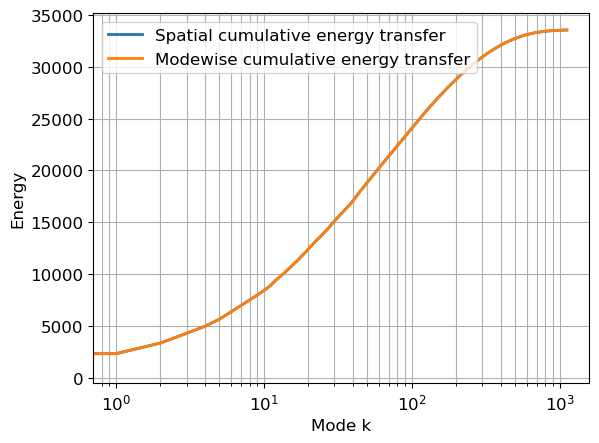

Total loss= 33553.843956018296


In [73]:
# %matplotlib qt
%matplotlib inline

dx = POD['x_all'][1,0] - POD['x_all'][0,0] # spacing in x
dy = POD['y_all'][0,1] - POD['y_all'][0,0] # spacing in y

# Spatial cumulative energy transfer
spatial_sum = np.sum(POD['uup'] + POD['uvp'] + POD['vup'] + POD['vvp'], axis=(0,1))
spatial_integral = spatial_sum * dx * dy
spatial_cumulative = np.cumsum(spatial_integral)

# Modewise cumulative energy transfer
modewise_cumulative = np.cumsum(POD['PLp'])

plt.figure(1)

# How much energy transfer have I captured by integrating up to mode k in physical space?
plt.plot(spatial_cumulative, linewidth=2, label='Spatial cumulative energy transfer')

# How much energy transfer have I captured by including mode k in POD mode space?
plt.plot(modewise_cumulative, linewidth=2, label='Modewise cumulative energy transfer')
plt.xscale('log')
plt.grid(which='both')
plt.xlabel('Mode k'); plt.ylabel('Energy');
plt.legend(loc='upper left')
plt.savefig((casename + r"/Figures/POD_Spatial_energy.png"),dpi=750, transparent=True) 
plt.show()

LOSS = np.sum(POD['PLp']); print('Total loss=', LOSS)

Text(0.5, 0, 'Snapshot')

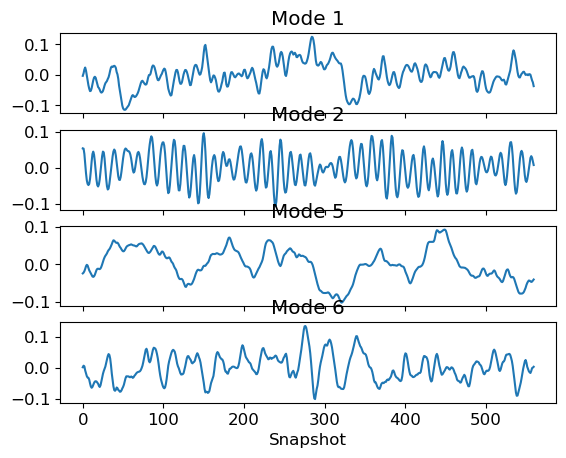

In [62]:
# %matplotlib qt
%matplotlib inline

modes = [0,1,4,5]
# modes = [0,1,2,3]

fig1, (ax, ax1, ax2, ax3) = plt.subplots(nrows=4, sharex=True)
ax.plot(POD['Chi'][:,modes[0]]); ax.set_title('Mode ' + str(modes[0]+1));
ax1.plot(POD['Chi'][:,modes[1]]); ax1.set_title('Mode ' + str(modes[1]+1));
ax2.plot(POD['Chi'][:,modes[2]]); ax2.set_title('Mode ' + str(modes[2]+1));
ax3.plot(POD['Chi'][:,modes[3]]); ax3.set_title('Mode ' + str(modes[3]+1));
ax3.set_xlabel('Snapshot')

### Mode fields

/tmp/ipykernel_2243543/3899390878.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cf = ax.pcolormesh(POD['x_plot'], POD['y_plot'], mode_u)
/tmp/ipykernel_2243543/3899390878.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cf = ax.pcolormesh(POD['x_plot'], POD['y_plot'], mode_v)


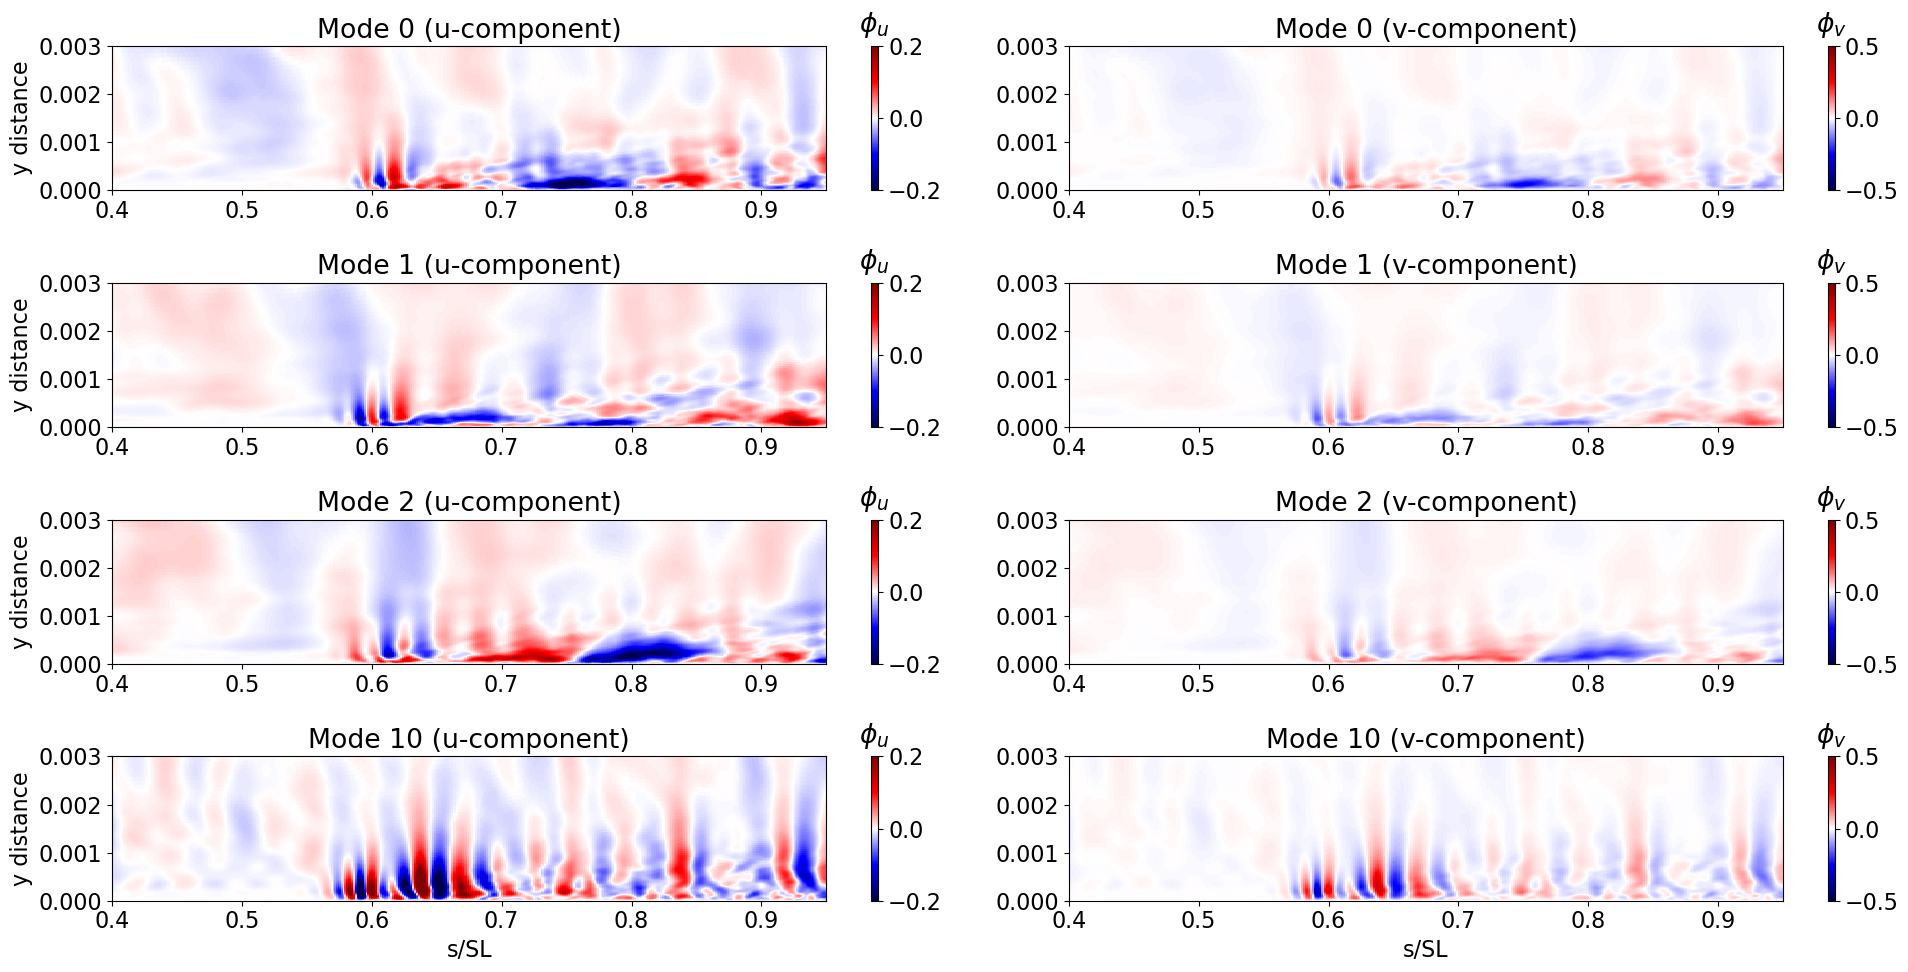

In [75]:
modes_to_plot = [0, 1, 2, 10] 
u_clims = [-0.2,0.2]
v_clims = [-0.5,0.5]
plt.rcParams['font.size'] = '16'
fig, axes = plt.subplots(nrows=len(modes_to_plot), ncols=2, figsize=(20, 10))
plt.set_cmap('seismic')
for i, mode_idx in enumerate(modes_to_plot):
    # Get the spatial mode
    mode_u = POD['Phi_u_norm'][:, :, mode_idx]
    mode_v = POD['Phi_u_norm'][:, :, mode_idx]
    
    # Plot u-component
    ax = axes[i, 0]
    cf = ax.pcolormesh(POD['x_plot'], POD['y_plot'], mode_u)
    cf.set_clim(u_clims)
    ax.set_ylabel(f'y distance')
    ax.set_title(f'Mode {mode_idx} (u-component)')
    cbar = fig.colorbar(cf, ax=ax)
    cbar.ax.set_title(r'$\phi_u$', pad=10)
    ax.axis([0.4, 0.95, 0, 0.003])
    
    # Plot v-component
    ax = axes[i, 1]
    cf = ax.pcolormesh(POD['x_plot'], POD['y_plot'], mode_v)
    cf.set_clim(v_clims)
    ax.set_title(f'Mode {mode_idx} (v-component)')
    cbar = fig.colorbar(cf, ax=ax)
    cbar.ax.set_title(r'$\phi_v$', pad=10)
    ax.axis([0.4, 0.95, 0, 0.003])
    
    if i == len(modes_to_plot) - 1:
        ax.set_xlabel('s/SL')
        axes[i, 0].set_xlabel('s/SL')

plt.tight_layout()
plt.savefig((casename + r"/Figures/POD_Spatial_modes_fields.png"),dpi=750, transparent=True) 
plt.show()

### PTKE fields

/tmp/ipykernel_2243543/2089779628.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cf = ax.pcolormesh(POD['x_plot'], POD['y_plot'], PTKE_uu)
/tmp/ipykernel_2243543/2089779628.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cf = ax.pcolormesh(POD['x_plot'], POD['y_plot'], PTKE_uv)


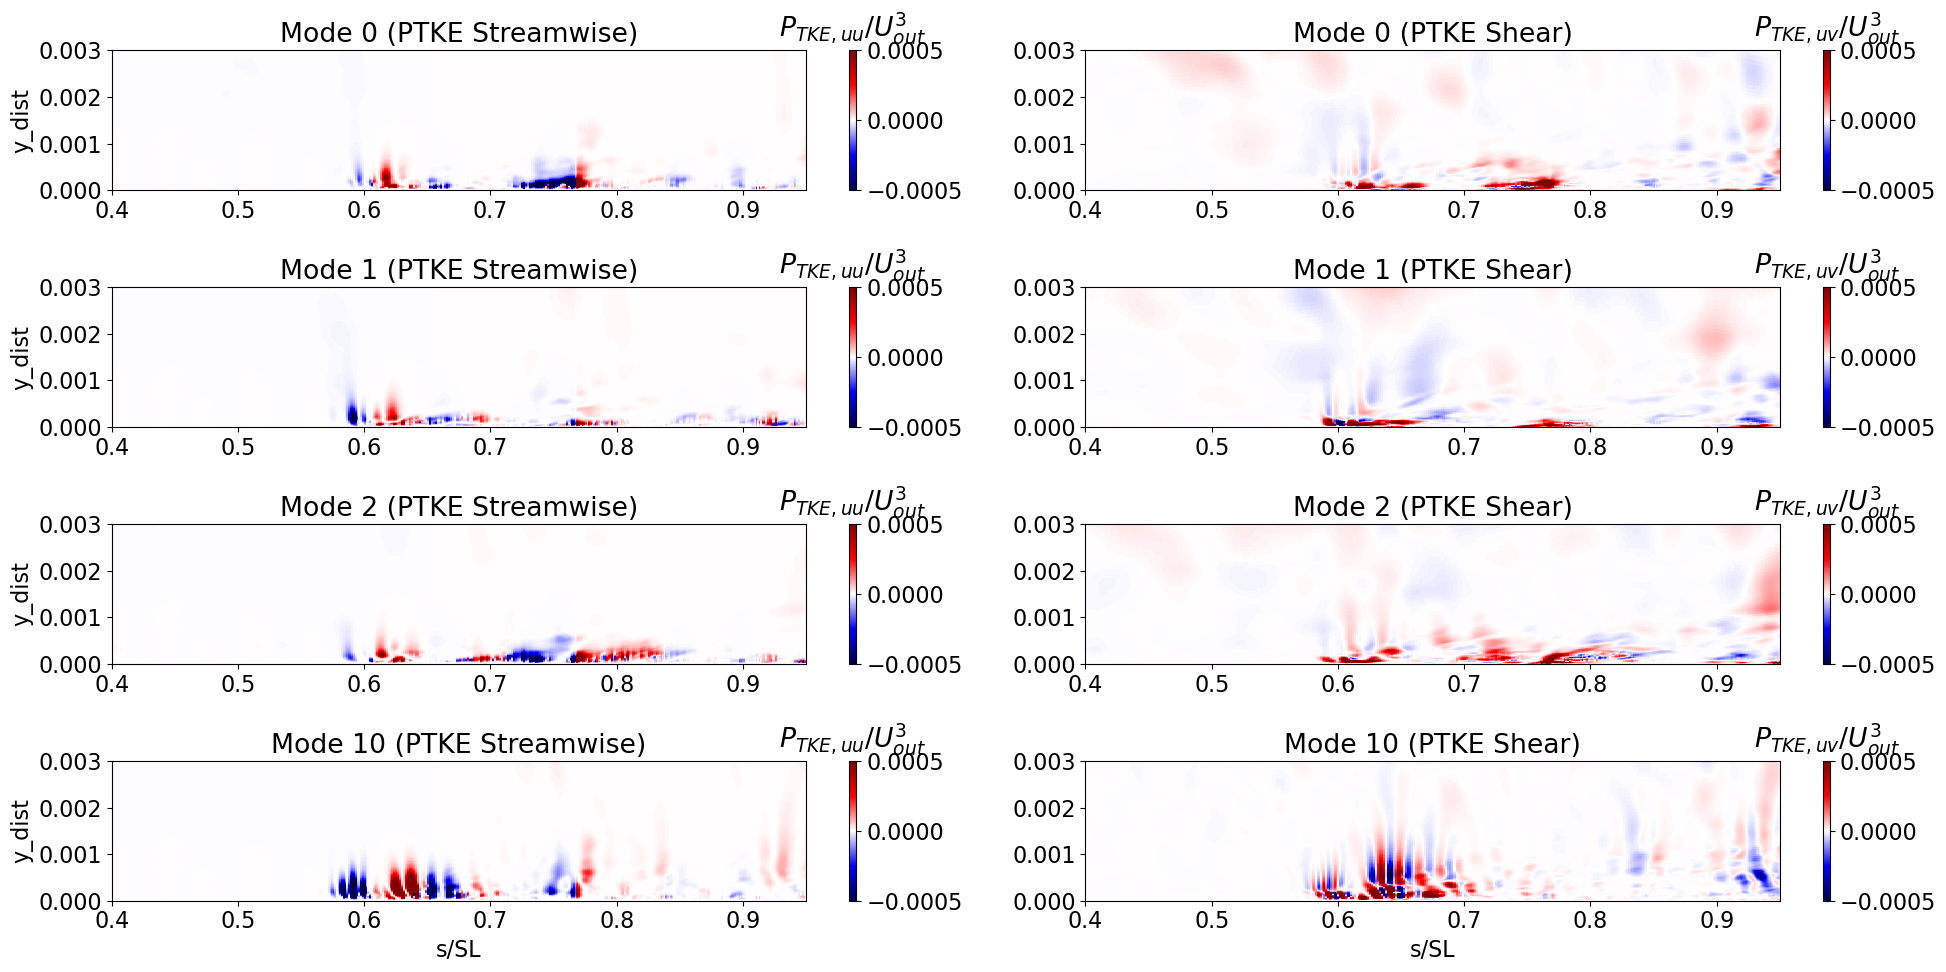

In [93]:
modes_to_plot = [0, 1, 2, 10] 
Uout = 17.5
# clims = [-round(10/Uout**3,3), round(10/Uout**3,3)]
clims = [-0.0005, 0.0005]
plt.rcParams['font.size'] = '16'
fig, axes = plt.subplots(nrows=len(modes_to_plot), ncols=2, figsize=(20, 10))
plt.set_cmap('seismic')
for i, mode_idx in enumerate(modes_to_plot):
    # Get the spatial PTKE production
    PTKE_uu = POD['uup'][:, :, mode_idx]
    PTKE_uv = POD['uvp'][:, :, mode_idx]
    
    # Plot uu-PTKE
    ax = axes[i, 0]
    cf = ax.pcolormesh(POD['x_plot'], POD['y_plot'], PTKE_uu)
    cf.set_clim(clims)
    ax.set_ylabel(f'y_dist')
    ax.set_title(f'Mode {mode_idx} (PTKE Streamwise)')
    cbar = fig.colorbar(cf, ax=ax)
    cbar.ax.set_title(r'$P_{TKE,uu}/U_{out}^3$', pad=10)
    ax.axis([0.4, 0.95, 0, 0.003])
    
    # Plot uv-PTKE
    ax = axes[i, 1]
    cf = ax.pcolormesh(POD['x_plot'], POD['y_plot'], PTKE_uv)
    cf.set_clim(clims)
    ax.set_title(f'Mode {mode_idx} (PTKE Shear)')
    cbar = fig.colorbar(cf, ax=ax)
    cbar.ax.set_title(r'$P_{TKE,uv}/U_{out}^3$', pad=10)
    ax.axis([0.4, 0.95, 0, 0.003])
    
    if i == len(modes_to_plot) - 1:
        ax.set_xlabel('s/SL')
        axes[i, 0].set_xlabel('s/SL')

plt.tight_layout()
plt.savefig((casename + r"/Figures/POD_PTKE_modes_fields.png"),dpi=750, transparent=True) 
plt.show()

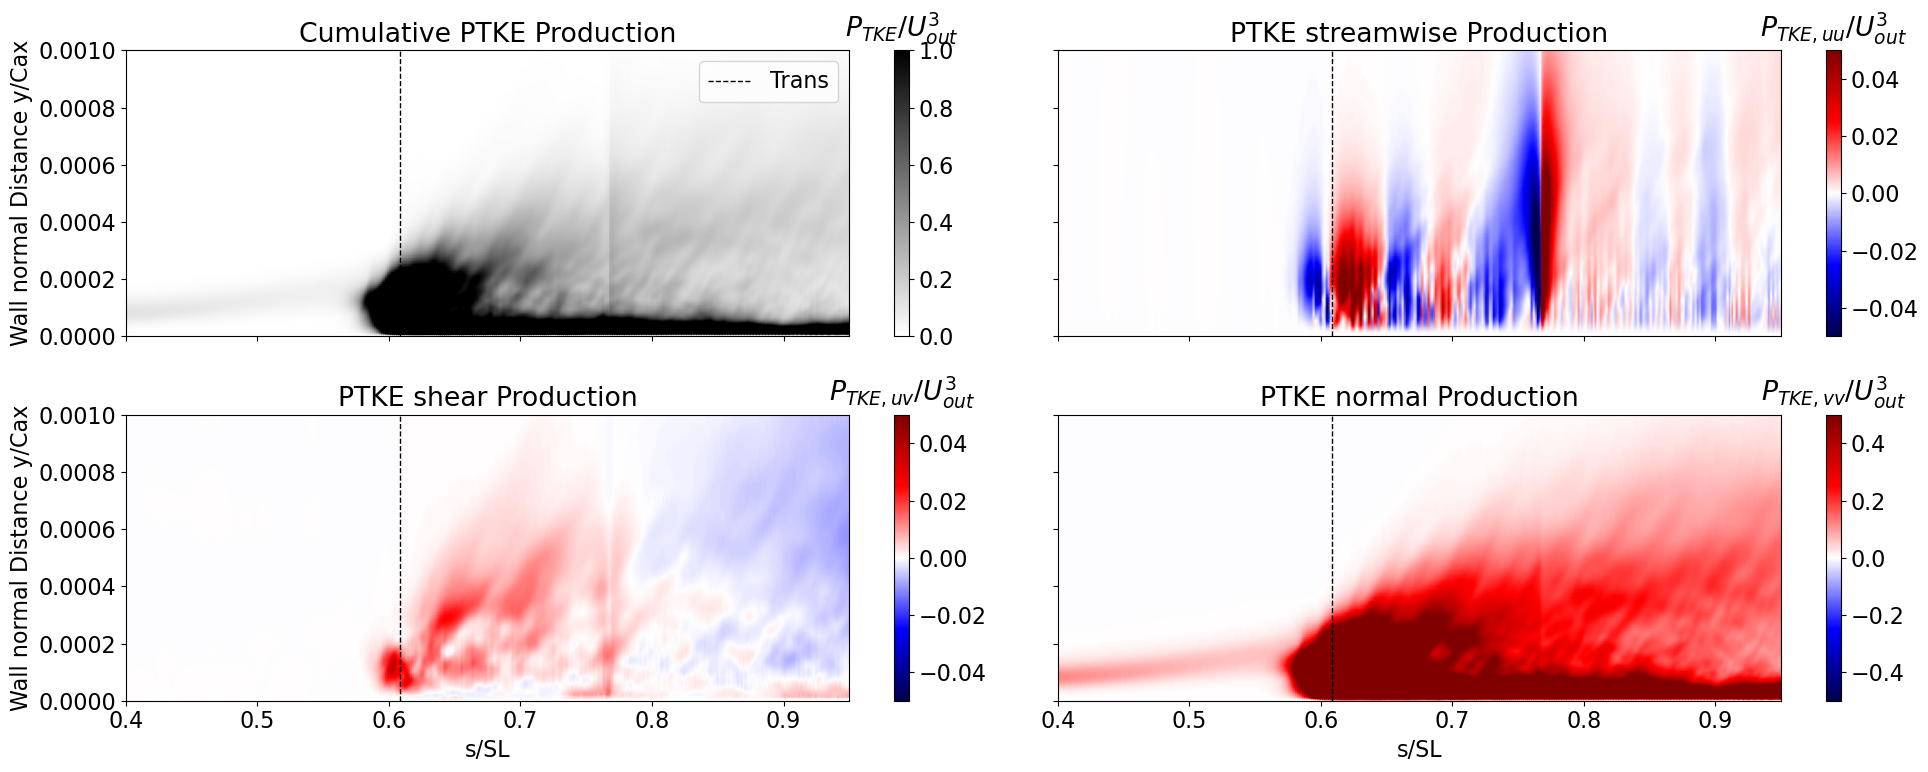

In [104]:
# Cumulative PTKE 
import pandas as pd

# %matplotlib qt
%matplotlib inline
plt.rcParams['font.size'] = '16'

uupCum = np.sum(POD['uup'], axis=2)
uvpCum = np.sum(POD['uvp'], axis=2)
vvpCum = np.sum(POD['vvp'], axis=2)
PlpCum = POD['PlpCum']

sep_trans = {"trans_ss_grad":0, "trans_ss_midp":0, "trans_ps_grad":0,
             "trans_ps_midp":0, "sep_ss":0, "reatt_ss":0,
             "sep_ps":0, "reatt_ps":0}
for key in sep_trans:
    sep_trans[key] = pd.read_csv(os.path.join(casename, key + '.csv'))['s/SL'].item()

clims = [-0.05, 0.05]
axislims = [0.4, 0.95, 0, 0.001]


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,8), sharex=True, sharey=True)
plt.set_cmap('seismic')

ax = axes.flat[0]
im = ax.pcolormesh(POD['x_plot'], POD['y_plot'], PlpCum, shading='gouraud',vmin=0, vmax=1,cmap='binary')
# im.set_clim(clim)
ax.set_title(f'Cumulative PTKE Production')
ax.set_ylabel('Wall normal Distance y/Cax')
ax.axis(axislims)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_title(r'$P_{TKE}/U_{out}^3$', pad=10)
if sep_trans['sep_ss'] > 0:
    ax.axvline(sep_trans['sep_ss'], color='k', linestyle='dotted', linewidth=1,label='Sep')
ax.axvline(sep_trans['trans_ss_grad'], color='k', linestyle='dashed', linewidth=1,label='Trans')
if sep_trans['reatt_ss'] > 0:
    ax.axvline(sep_trans['reatt_ss'], color='k', linestyle='dashdot', linewidth=1,label='Reatt')
ax.legend()

ax1 = axes.flat[1]
im = ax1.pcolormesh(POD['x_plot'], POD['y_plot'], uupCum, shading='gouraud')
im.set_clim(clims)
ax1.set_title(f'PTKE streamwise Production')
ax1.axis(axislims)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_title(r'$P_{TKE,uu}/U_{out}^3$', pad=10)
if sep_trans['sep_ss'] > 0:
    ax1.axvline(sep_trans['sep_ss'], color='k', linestyle='dotted', linewidth=1,label='Sep')
ax1.axvline(sep_trans['trans_ss_grad'], color='k', linestyle='dashed', linewidth=1,label='Trans')
if sep_trans['reatt_ss'] > 0:
    ax1.axvline(sep_trans['reatt_ss'], color='k', linestyle='dashdot', linewidth=1,label='Reatt')


ax2 = axes.flat[2]
im = ax2.pcolormesh(POD['x_plot'], POD['y_plot'], uvpCum, shading='gouraud')
im.set_clim(clims)
ax2.set_title(f'PTKE shear Production')
ax2.set_ylabel('Wall normal Distance y/Cax')
ax2.set_xlabel('s/SL')
ax2.axis(axislims)
cbar = fig.colorbar(im, ax=ax2)
cbar.ax.set_title(r'$P_{TKE,uv}/U_{out}^3$', pad=10)
if sep_trans['sep_ss'] > 0:
    ax2.axvline(sep_trans['sep_ss'], color='k', linestyle='dotted', linewidth=1,label='Sep')
ax2.axvline(sep_trans['trans_ss_grad'], color='k', linestyle='dashed', linewidth=1,label='Trans')
if sep_trans['reatt_ss'] > 0:
    ax2.axvline(sep_trans['reatt_ss'], color='k', linestyle='dashdot', linewidth=1,label='Reatt')

clims = [-0.5, 0.5]
ax3 = axes.flat[3]
im = ax3.pcolormesh(POD['x_plot'], POD['y_plot'], vvpCum, shading='gouraud')
im.set_clim(clims)
ax3.set_title(f'PTKE normal Production')
ax3.set_xlabel('s/SL')
ax3.axis(axislims)
cbar = fig.colorbar(im, ax=ax3)
cbar.ax.set_title(r'$P_{TKE,vv}/U_{out}^3$', pad=10)
if sep_trans['sep_ss'] > 0:
    ax3.axvline(sep_trans['sep_ss'], color='k', linestyle='dotted', linewidth=1,label='Sep')
ax3.axvline(sep_trans['trans_ss_grad'], color='k', linestyle='dashed', linewidth=1,label='Trans')
if sep_trans['reatt_ss'] > 0:
    ax3.axvline(sep_trans['reatt_ss'], color='k', linestyle='dashdot', linewidth=1,label='Reatt')


plt.tight_layout()

plt.savefig((casename + r"/Figures/POD_PTKE_fields.png"),dpi=750, transparent=True) 

plt.show()

### Original field debugging

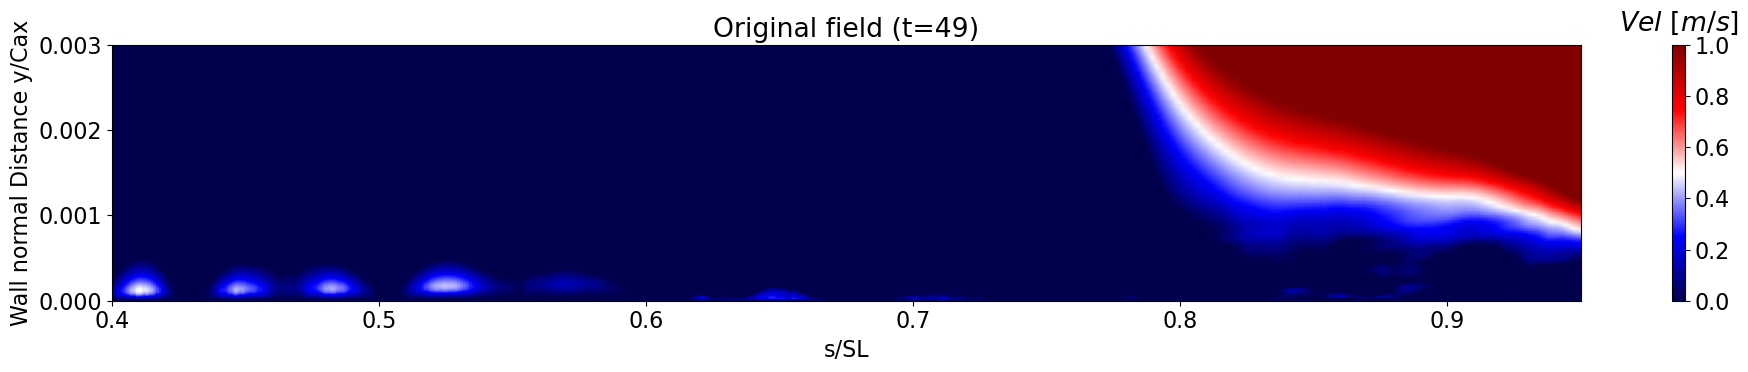

In [26]:
# Time snapshot
t_idx = 49
# t_idx = 500

plt.rcParams['font.size'] = '16'

fig,ax = plt.subplots(figsize=(20,4))
plt.set_cmap('seismic')

clim = [-1,1]
clim = [0,1]
# clim = [0,5]

plot_data = POD['MU'].reshape(POD['Nx'], POD['Ny'], order='F')
# plot_data = POD['Up'][:,t_idx].reshape(POD['Nx'], POD['Ny'], order='F')
# plot_data = POD['uRMS'].reshape(POD['Nx'], POD['Ny'], order='F')
# plot_data = POD['vRMS'].reshape(POD['Nx'], POD['Ny'], order='F')


im = plt.pcolormesh(POD['x_plot'], POD['y_plot'], plot_data, shading='gouraud')
# plt.streamplot(x_plot, y_plot, MU.reshape(Nx, Ny, order='F'), MV.reshape(Nx, Ny, order='F'), broken_streamlines=False)
# plt.quiver(x_plot, y_plot, MU.reshape(Nx, Ny, order='F'), MV.reshape(Nx, Ny, order='F'))
im.set_clim(clim)
plt.title(f'Original field (t={t_idx})')
plt.ylabel('Wall normal Distance y/Cax')
plt.xlabel('s/SL')
plt.axis([0.4, 0.95, 0, 0.003])
cbar = fig.colorbar(im, ax=ax, location='right')
cbar.ax.set_title(r"$Vel \ [m/s]$", pad=10)
ax.set_ylabel('Wall normal Distance y/Cax')
ax.set_xlabel('s/SL')
# ax.legend(loc='upper left')
plt.tight_layout()

### POD reconstruction

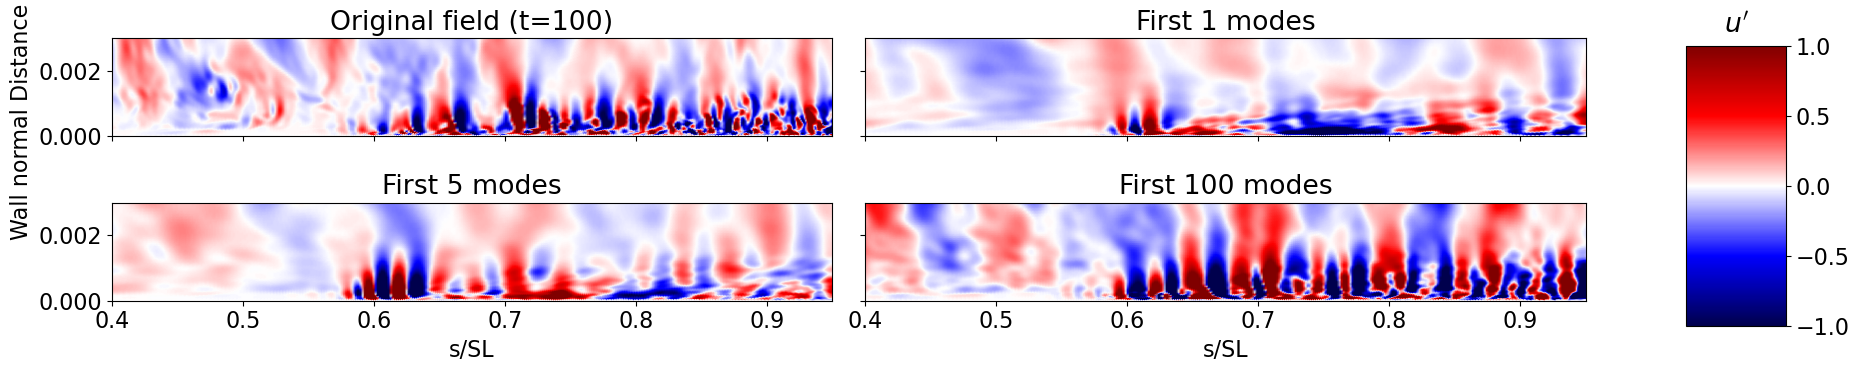

<Figure size 640x480 with 0 Axes>

In [77]:
# Low-rank reconstruction

# %matplotlib qt
%matplotlib inline

# Define the cumulative mode counts for reconstruction
reconstructions = [1, 5, 100]
clim = [-1, 1]

# Time snapshot for comparison
t_idx = 100

# Temporal coefficients
# a_t = Chi * np.sqrt(Lam)
a_t = POD['Chi']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,4), sharex=True, sharey=True)
plt.set_cmap('seismic')

ax = axes.flat[0]
u_orig = POD['Up'][:, t_idx].reshape(POD['Nx'], POD['Ny'], order='F')
im = ax.pcolormesh(POD['x_plot'], POD['y_plot'], u_orig, shading='gouraud')
im.set_clim(clim)
ax.set_title(f'Original field (t={t_idx})')
ax.set_ylabel('Wall normal Distance y/Cax')


for i, n_modes in enumerate(reconstructions):
    ax = axes.flat[i+1]
    
    # POD reconstruction: U' ≈ Φ_u_norm * a_t
    # Compute fluctuation field at chosen time
    # u_recon_fluc = np.sum(Phi_u_norm[:, :, :n_modes] * a_t[t_idx, :n_modes], axis=2)
    u_recon_fluc = np.tensordot(POD['Phi_u_norm'][:, :, :n_modes], a_t[t_idx, :n_modes], axes=([2], [0]))

    # Purely for plotting - normalised to max of original field
    u_recon_vis = u_recon_fluc / np.max(np.abs(u_recon_fluc)) * np.max(np.abs(u_orig))


    
    im = ax.pcolormesh(POD['x_plot'], POD['y_plot'], u_recon_vis, shading='gouraud')
    im.set_clim(clim)
    # im.set_clim(-0.05,0.05)
    ax.set_title(f'First {n_modes} modes')
    plt.axis([0.4, 0.95, 0, 0.003])
    plt.tight_layout()
    
    # Axis labels
    if i in [1,2]:
        ax.set_xlabel('s/SL')
    # if i == 1:
    #     ax.set_ylabel('Wall Normal Distance y/Cax')

# Shared colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"$u'$", pad=10)

plt.show()
plt.savefig((casename + r"/Figures/POD_Reconstruction.png"),dpi=750, transparent=True) 


### Animations

In [ ]:
from postpro.POD_animation_prime import *

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'
FPS = 20
DPI = 250
frames_to_render = 10
dt = 2500*8e-8
component = 'Wp'
POD_animation_prime(casename, FPS, DPI, frames_to_render, dt, component)

Loading data from 'animation_data.npz'...
...Data loaded. Found 560 snapshots.
Setting up plot...
Generating animation (560 frames)...
Saving animation to '/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean/Figures/POD_reconstruction_Up_animation_560Nt.gif'...

Animation saved successfully to '/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean/Figures/POD_reconstruction_Up_animation_560Nt.gif'!



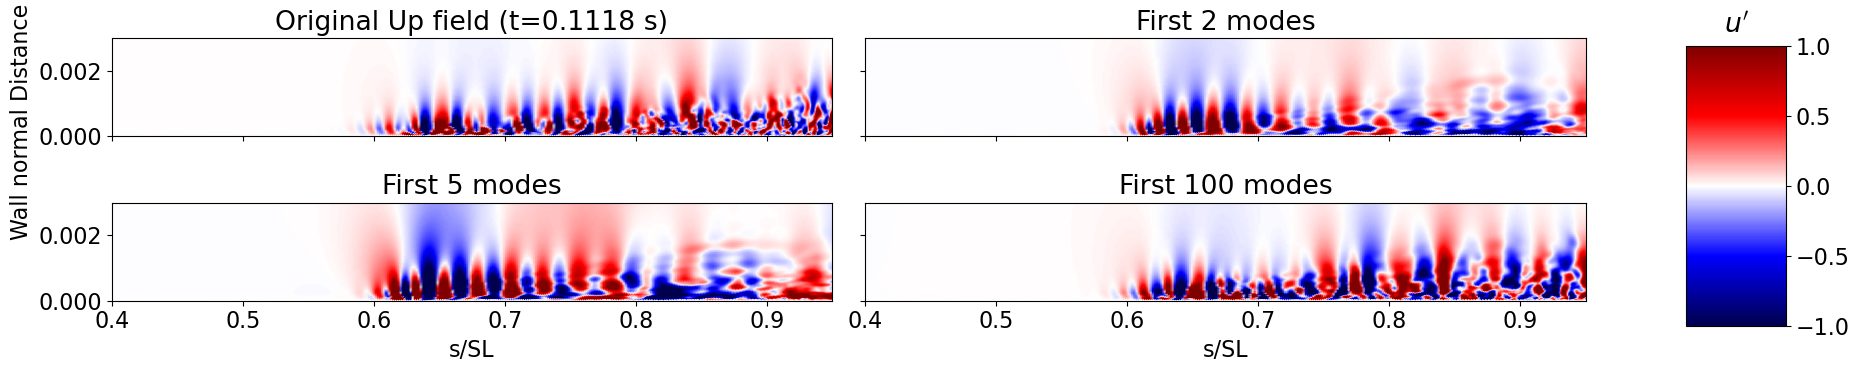

In [7]:
from postpro.POD_animation_reconstruction import *

casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
FPS = 20
DPI = 250
frames_to_render = 10
frames_to_render = -1
dt = 2500*8e-8
reconstructions = [2,5,100]
u_normalisation = 5
component = 'Up'
POD_animation_reconstruction(casename, FPS, DPI, frames_to_render, dt, reconstructions, u_normalisation, component)

### Spectral analysis

Starting Spectrogram analysis of POD temporal coefficients (Chi)...
Using Sampling Frequency (Fs): 5000.00 Hz
Time step between POD snapshots (dt): 2.00e-04 s
Computing FFT for each mode...
Plotting Spectrogram for the top 1120 modes...


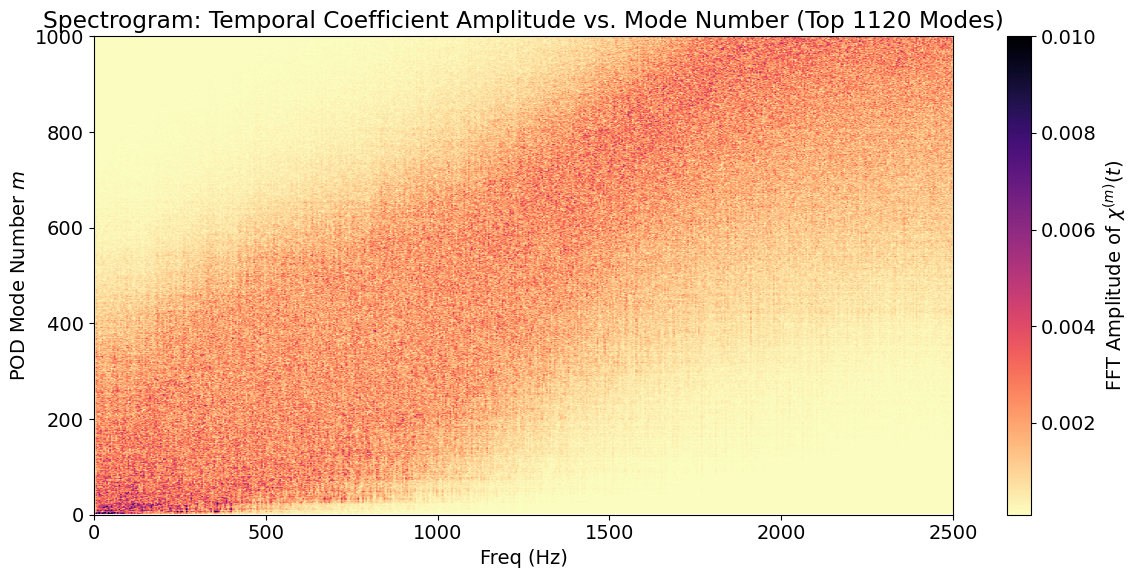

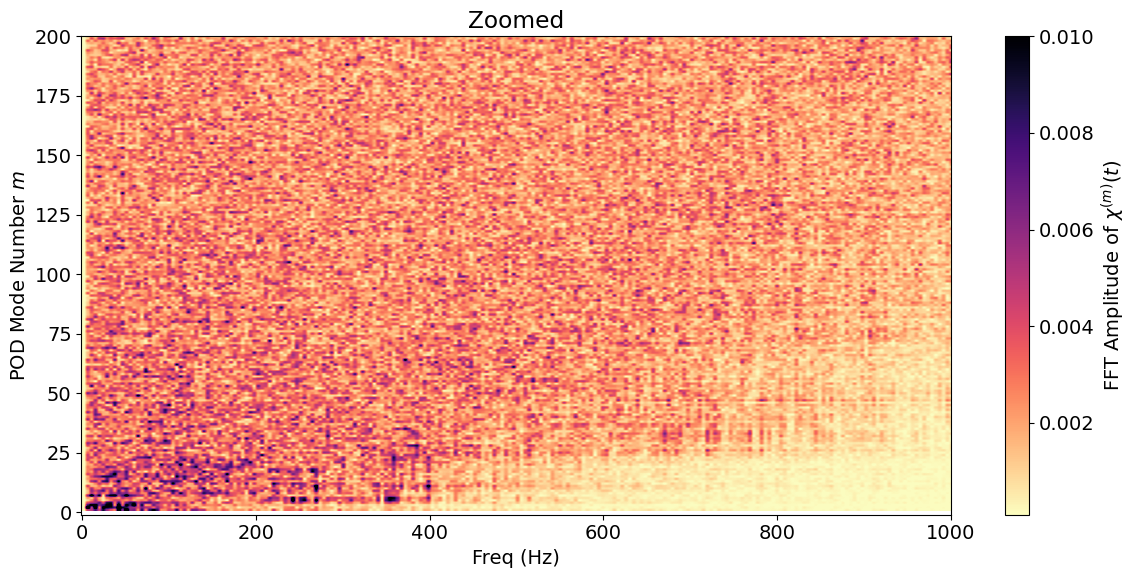

Spectrogram analysis complete.


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors # Import for LogNorm
plt.rcParams['font.size'] = '14'

print("Starting Spectrogram analysis of POD temporal coefficients (Chi)...")

# --- Spectrogram Setup ---
# Chi is the matrix of temporal coefficients: shape (Nt, Nr)
# where Nt = number of snapshots, Nr = number of modes
Nt = POD['Chi'].shape[0] # Get Nt directly from the data
Nr = POD['Chi'].shape[1] # Total number of modes

# Choose a reasonable number of modes to analyze
Nm = 300 # Number of modes to analyze
Nm = 2000
if Nm > Nr:
    Nm = Nr

Chi_Nm = POD['Chi'][:, :Nm] # (Nt, Nm)

# --- Frequency Data  ---
# sampling frequency is 1 snapshot per (2500 * 8e-8 seconds)
Fs = 1.0 / (2500 * 8e-8)
dt = 1.0 / Fs # Time step between snapshots
print(f"Using Sampling Frequency (Fs): {Fs:.2f} Hz")
print(f"Time step between POD snapshots (dt): {dt:.2e} s")

# --- Perform FFT on each mode's temporal coefficient ---
# We use the full Nt time points for the FFT
N_fft = Nt 

# Get the frequency axis for a one-sided (real) FFT
# This correctly goes from 0 Hz up to the Nyquist frequency (Fs / 2)
frequencies_pos = np.fft.rfftfreq(N_fft, d=dt)
N_freqs = len(frequencies_pos)

# FFT Amplitude storage: (Num_Positive_Freqs, Nm)
fft_amplitude = np.zeros((N_freqs, Nm))

print("Computing FFT for each mode...")
for m in range(Nm):
    # Compute the one-sided FFT (for real signals)
    chi_m_rfft = np.fft.rfft(Chi_Nm[:, m])
    
    # Get the amplitude and normalize by N_fft
    # This gives the amplitude of the "zero-to-peak" sine component
    chi_m_amplitude = np.abs(chi_m_rfft) / N_fft
    
    # Correct for single-sided spectrum:
    # Double all amplitudes *except* for DC (0 Hz, index 0)
    # and the Nyquist frequency (last index, if N_fft is even)
    chi_m_amplitude[1:] = chi_m_amplitude[1:] * 2
    
    # If N_fft is even, the last element is the Nyquist frequency,
    # which should not be doubled.
    if N_fft % 2 == 0:
        chi_m_amplitude[-1] = chi_m_amplitude[-1] / 2
    
    # Store the result
    fft_amplitude[:, m] = chi_m_amplitude

# --- Plotting the Spectrogram ---
print(f"Plotting Spectrogram for the top {Nm} modes...")

# Use a reversed 'magma' colormap
try:
    orig_map = plt.colormaps.get_cmap('magma')
    # orig_map = plt.colormaps.get_cmap('Oranges')
    reversed_map = orig_map.reversed()
    # reversed_map = orig_map
except AttributeError: # For newer Matplotlib versions
    reversed_map = plt.colormaps.get_cmap('magma_r')

plt.figure(1,figsize=(12, 6))
# Get data for plotting
plot_data = fft_amplitude.T # (Nm, N_freqs)

# Find min/max for log scale, avoiding log(0)
min_val = np.min(plot_data[plot_data > 0])
max_val = np.max(plot_data)
min_val = 1e-4
max_val = 0.01

im = plt.imshow(
    plot_data,
    aspect='auto',
    origin='lower',
    # Use LogNorm for better visibility of spectral features
    # norm=colors.LogNorm(vmin=min_val, vmax=max_val),
    vmin=min_val,
    vmax=max_val,
    extent=[frequencies_pos.min(), frequencies_pos.max(), 0.5, Nm + 0.5],
    cmap=reversed_map
)

plt.colorbar(im, label=r'FFT Amplitude of $\chi^{(m)}(t)$')
plt.xlabel('Freq (Hz)') # Label is now in Hz
plt.ylabel('POD Mode Number $m$')
plt.title(f'Spectrogram: Temporal Coefficient Amplitude vs. Mode Number (Top {Nm} Modes)')
plt.grid(False)

# Set x-limit to show the full range from 0 to Nyquist frequency
plt.xlim(0, frequencies_pos.max()) 

plt.ylim(0, Nm + 0.5)
plt.ylim(0, 1000)
plt.tight_layout()
plt.savefig((casename + r"/Figures/POD_Spectogram.png"),dpi=750, transparent=True) 
plt.show()

plt.figure(2,figsize=(12, 6))
# Get data for plotting
plot_data = fft_amplitude.T # (Nm, N_freqs)

# Find min/max for log scale, avoiding log(0)
min_val = np.min(plot_data[plot_data > 0])
max_val = np.max(plot_data)
min_val = 1e-4
max_val = 0.01

im = plt.imshow(
    plot_data,
    aspect='auto',
    origin='lower',
    # Use LogNorm for better visibility of spectral features
    # norm=colors.LogNorm(vmin=min_val, vmax=max_val),
    vmin=min_val,
    vmax=max_val,
    extent=[frequencies_pos.min(), frequencies_pos.max(), 0.5, Nm + 0.5],
    cmap=reversed_map
)

plt.colorbar(im, label=r'FFT Amplitude of $\chi^{(m)}(t)$')
plt.xlabel('Freq (Hz)') # Label is now in Hz
plt.ylabel('POD Mode Number $m$')
plt.title(f'Zoomed')
plt.grid(False)

# Set x-limit to show the full range from 0 to Nyquist frequency
plt.xlim(-1, 1000) 

plt.ylim(-1, 200)
plt.tight_layout()
plt.savefig((casename + r"/Figures/POD_Spectogram_zoomed.png"),dpi=750, transparent=True) 
plt.show()

print("Spectrogram analysis complete.")

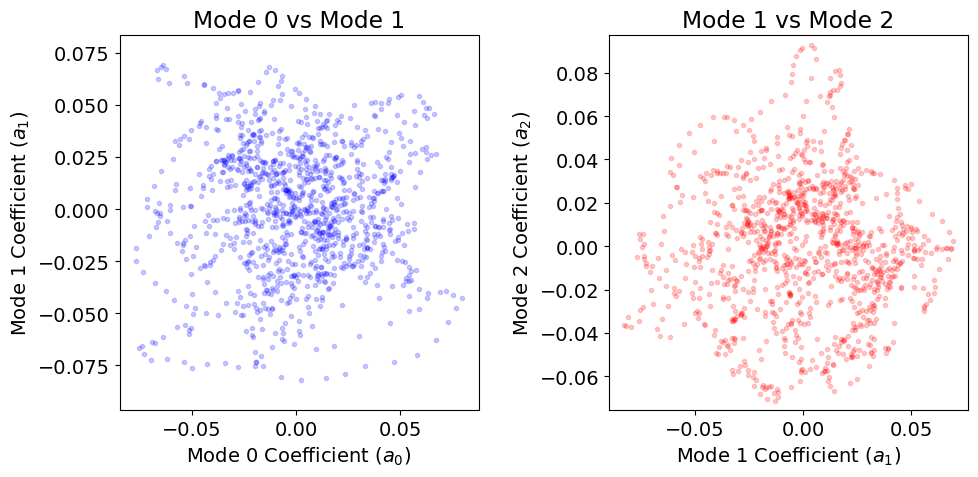

In [65]:
# Phase-Space Portraits
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(10, 5))

# Plot Mode 0 vs Mode 1
plt.subplot(1, 2, 1)
plt.plot(POD['Chi'][:, 0], POD['Chi'][:, 1], 'b.', alpha=0.2)
plt.xlabel('Mode 0 Coefficient ($a_0$)')
plt.ylabel('Mode 1 Coefficient ($a_1$)')
plt.title('Mode 0 vs Mode 1')
plt.axis('equal')

# Plot Mode 1 vs Mode 2
plt.subplot(1, 2, 2)
plt.plot(POD['Chi'][:, 1], POD['Chi'][:, 2], 'r.', alpha=0.2)
plt.xlabel('Mode 1 Coefficient ($a_1$)')
plt.ylabel('Mode 2 Coefficient ($a_2$)')
plt.title('Mode 1 vs Mode 2')
plt.axis('equal')

# Plot Mode 3 vs Mode 3
# plt.subplot(1, 2, 2)
# plt.plot(Chi[:, 2], Chi[:, 3], 'r.', alpha=0.2)
# plt.xlabel('Mode 2 Coefficient ($a_2$)')
# plt.ylabel('Mode 3 Coefficient ($a_3$)')
# plt.title('Mode 2 vs Mode 3')
# plt.axis('equal')


plt.tight_layout()
plt.savefig((casename + r"/Figures/POD_Phase_diagrams.png"),dpi=750, transparent=True) 
plt.show()

If two modes represent a convecting or oscillating structure, their temporal coefficients Chi[:, m] and Chi[:, n] might be 90 degrees out of phase, which creates a circle or ellipse when plotted against each other.

## SPOD

In [2]:
from postpro.SPOD_v1 import *

blocks = [4,6] # nothing interesting in 2 and sometimes it contains NaNs
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesclean'
casename = r'/gpfs/scratch/acad/turbodns/pcassidy/LSSPLEEN/outputs/td/meshsensitivityshort/coarsesturb'
nfiles = [100]
nfiles = [560]
nfiles = [1120]
dt = 2500 * 8e-8
# window = 64 # 'hamming'
window = 512
weight = None
n_overlap = None # default is 50% of window, accepted best practice
n_fft = None
method = 'fast'
conflvl = 0.95
save_fft = False
save_dir = (casename + r"/SPOD")
SPOD = SPOD_v1(casename, nfiles, blocks, dt, window, weight, n_overlap, n_fft, method, conflvl, save_fft, save_dir)

Starting SPOD analysis
Reading 1120 snapshots...
Data loading complete.
Calculating grid transformation...
Applying transformation to all velocity snapshots...
Creating new rectangular 'box' grid for calculation...
Creating new physical 'plotting' grid (x_plot, y_plot)...
... 'x_plot' and 'y_plot' created for plotting.
  y_plot wall (j=143) min/max: 0.00e+00, 0.00e+00
  y_plot far-field (j=0) min/max: 0.004, 0.008
  x_plot (s/SL) start/end: 0.1351, 1.0000
Transformation complete. Starting POD...
Shape of UV matrix: (248832, 1120)
Shape of transposed UV matrix: (1120, 248832)
Calculating Temporal DFT. Blocks: 3, FFT Size: 512
Calculating SPOD modes...
Script finished.


Text(0, 0.5, 'Mode energy')

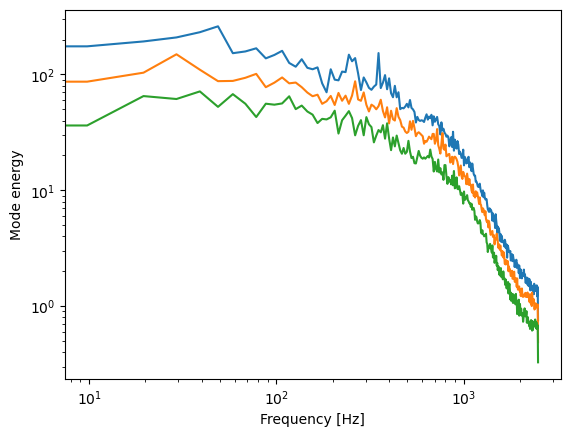

In [3]:
plt.figure(1)
plt.plot(SPOD['f'], SPOD['L'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mode energy')

In [15]:
print(SPOD['P'].shape)
Nx = 864
Ny = 144
Nt = 1120
print(SPOD['P'][0,:,0].reshape(Nx, Ny, order='F'))

(33, 248832, 34)


ValueError: cannot reshape array of size 248832 into shape (864,144)